In [1]:
# Cell 1: Check and Install Required Libraries
# Run this first to install all necessary packages

import subprocess
import sys


def install_if_missing(package):
    """Install package if not already installed"""
    try:
        __import__(package.split('==')[0])
        print(f"✅ {package.split('==')[0]} is already installed")
    except ImportError:
        print(f"📦 Installing {package}...")
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")


# Core data science libraries
packages = [
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "scipy",
    "scikit-learn",
    "plotly",
    "jupyter",
]

# Sleep/EEG specific libraries
sleep_packages = [
    "mne",           # For EEG/polysomnography data
    "pyedflib",      # For reading EDF files
    "xlrd",          # For reading Excel files
    "openpyxl",      # For reading modern Excel files
]

# Report generation libraries
report_packages = [
    "reportlab",     # For PDF generation
    "jinja2",        # For report templates
    "fpdf",          # Alternative PDF library
]

print("🔍 Checking core data science libraries...")
for package in packages:
    install_if_missing(package)

print("\n🧠 Checking sleep/EEG specific libraries...")
for package in sleep_packages:
    install_if_missing(package)

print("\n📄 Checking report generation libraries...")
for package in report_packages:
    install_if_missing(package)

print("\n✅ All libraries installation check complete!")
print("🚀 Ready to proceed with Sleep-EDF analysis!")

🔍 Checking core data science libraries...
✅ numpy is already installed
✅ pandas is already installed
✅ matplotlib is already installed
✅ seaborn is already installed
✅ scipy is already installed
📦 Installing scikit-learn...
✅ scikit-learn installed successfully
✅ plotly is already installed
✅ jupyter is already installed

🧠 Checking sleep/EEG specific libraries...
✅ mne is already installed
✅ pyedflib is already installed
✅ xlrd is already installed
✅ openpyxl is already installed

📄 Checking report generation libraries...
✅ reportlab is already installed
✅ jinja2 is already installed
📦 Installing fpdf...
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  DEPRECATION: Building 'fpdf' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'fpdf'. Discussion can be found at https://github.com/pypa/pip/issues/6334


  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40759 sha256=28516b6948f39586ec016a746cc982d935e23bafcf0cf292ff8218d35449e027
  Stored in directory: /Users/rishabh/Library/Caches/pip/wheels/44/35/8b/86ce00cec7e4d13c5f189680ae0fa82f919bedc066c2cddae9
Successfully built fpdf
✅ fpdf installed successfully

✅ All libraries installation check complete!
🚀 Ready to proceed with Sleep-EDF analysis!


In [2]:
# Cell 2: Import Libraries and Setup Configuration
import os
import sys
import warnings
from pathlib import Path
import pickle

# Core data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Sleep/EEG specific libraries
import mne
import pyedflib

# Report and visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# System and file handling
import glob
import datetime
from typing import Dict, List, Tuple, Optional

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure MNE to be less verbose
mne.set_log_level('WARNING')

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Create project directory structure


def setup_project_structure():
    """Create the necessary directory structure matching your existing structure"""
    base_dir = Path("../")

    directories = [
        # Results subdirectories for Sleep-EDF analysis
        "results/sleep-edf/processed",
        "results/sleep-edf/features",
        "results/sleep-edf/models",
        "results/sleep-edf/visualizations",
        # Reports subdirectories
        "reports/sleep-edf"
    ]

    for dir_path in directories:
        full_path = base_dir / dir_path
        full_path.mkdir(parents=True, exist_ok=True)

    print("✅ Project directory structure updated successfully!")
    return base_dir


# Setup project structure
project_base = setup_project_structure()

# Define paths based on your existing structure
SLEEP_EDF_RAW = project_base / "datasets/sleep-edf-database-expanded-1.0.0"
SLEEP_EDF_PROCESSED = project_base / "results/sleep-edf/processed"
SLEEP_EDF_FEATURES = project_base / "results/sleep-edf/features"
SLEEP_EDF_MODELS = project_base / "results/sleep-edf/models"
SLEEP_EDF_VISUALIZATIONS = project_base / "results/sleep-edf/visualizations"
REPORTS_DIR = project_base / "reports/sleep-edf"

# Validate raw data directory exists
if not SLEEP_EDF_RAW.exists():
    print(f"⚠️  Warning: Raw data directory not found at {SLEEP_EDF_RAW}")
    print("   Please ensure the sleep-edf-database-expanded-1.0.0 folder is in datasets/")
else:
    print("✅ Raw data directory found successfully!")

print("🎯 Current working directory:", os.getcwd())
print("📁 Sleep-EDF raw data path:", SLEEP_EDF_RAW)
print("📊 Sleep-EDF processed data path:", SLEEP_EDF_PROCESSED)
print("🔬 Sleep-EDF features path:", SLEEP_EDF_FEATURES)
print("🤖 Sleep-EDF models path:", SLEEP_EDF_MODELS)
print("📈 Sleep-EDF visualizations path:", SLEEP_EDF_VISUALIZATIONS)
print("📋 Reports directory:", REPORTS_DIR)

# Configuration dictionary
CONFIG = {
    'sampling_rate': 100,  # Hz - typical for EEG
    'chunk_size': 30,      # seconds - standard epoch size
    'freq_bands': {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (12, 30),
        'gamma': (30, 50)
    },
    'sleep_stages': {
        'W': 'Wake',
        'R': 'REM',
        '1': 'N1',
        '2': 'N2',
        '3': 'N3',
        '4': 'N4',
        'M': 'Movement',
        '?': 'Unknown'
    }
}

print("\n⚙️  Configuration loaded:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

print("\n🚀 Setup complete! Ready for Sleep-EDF data analysis.")
print("📂 Directory structure with clear separation of concerns:")
print("   📁 Raw Data: datasets/sleep-edf-database-expanded-1.0.0/ (unchanged)")
print("   📊 Processed Data & Features: results/sleep-edf/")
print("   📈 Visualizations: results/sleep-edf/visualizations/")
print("   🤖 Models: results/sleep-edf/models/")
print("   📋 Reports: reports/sleep-edf/")
print("📋 Next step: Data acquisition and file examination")

✅ Project directory structure updated successfully!
✅ Raw data directory found successfully!
🎯 Current working directory: /Users/rishabh/Documents/BDA-course/HDA3/notebooks
📁 Sleep-EDF raw data path: ../datasets/sleep-edf-database-expanded-1.0.0
📊 Sleep-EDF processed data path: ../results/sleep-edf/processed
🔬 Sleep-EDF features path: ../results/sleep-edf/features
🤖 Sleep-EDF models path: ../results/sleep-edf/models
📈 Sleep-EDF visualizations path: ../results/sleep-edf/visualizations
📋 Reports directory: ../reports/sleep-edf

⚙️  Configuration loaded:
   sampling_rate: 100
   chunk_size: 30
   freq_bands: {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 50)}
   sleep_stages: {'W': 'Wake', 'R': 'REM', '1': 'N1', '2': 'N2', '3': 'N3', '4': 'N4', 'M': 'Movement', '?': 'Unknown'}

🚀 Setup complete! Ready for Sleep-EDF data analysis.
📂 Directory structure with clear separation of concerns:
   📁 Raw Data: datasets/sleep-edf-database-expanded-1.0.0/ (unch

In [5]:
# Cell 3: Data Acquisition and File Examination

def examine_sleep_edf_structure():
    """Examine the Sleep-EDF dataset structure and files"""

    print("🔍 Examining Sleep-EDF Dataset Structure...")
    print("=" * 60)

    # Check if raw data directory exists
    if not SLEEP_EDF_RAW.exists():
        print(f"❌ Error: Raw data directory not found at {SLEEP_EDF_RAW}")
        return None

    # Get all files recursively (including subdirectories)
    all_files = list(SLEEP_EDF_RAW.rglob("*"))
    files_only = [f for f in all_files if f.is_file()]

    print(f"📁 Total files found: {len(files_only)}")
    print(f"📂 Raw data directory: {SLEEP_EDF_RAW}")

    # Examine subdirectory structure
    subdirs = [d for d in SLEEP_EDF_RAW.iterdir() if d.is_dir()]
    print(f"📂 Subdirectories found: {[d.name for d in subdirs]}")

    # Categorize files
    file_categories = {
        'SC_PSG': [],      # Sleep Cassette PSG files
        'ST_PSG': [],      # Sleep Telemetry PSG files
        'SC_Hypnogram': [],  # Sleep Cassette Hypnograms
        'ST_Hypnogram': [],  # Sleep Telemetry Hypnograms
        'Excel': [],        # Excel metadata files
        'Other': []         # Other files
    }

    # Categorize each file
    for file_path in files_only:
        filename = file_path.name

        if filename.startswith('SC') and filename.endswith('PSG.edf'):
            file_categories['SC_PSG'].append(file_path)
        elif filename.startswith('ST') and filename.endswith('PSG.edf'):
            file_categories['ST_PSG'].append(file_path)
        elif filename.startswith('SC') and 'Hypnogram' in filename:
            file_categories['SC_Hypnogram'].append(file_path)
        elif filename.startswith('ST') and 'Hypnogram' in filename:
            file_categories['ST_Hypnogram'].append(file_path)
        elif filename.endswith(('.xls', '.xlsx')):
            file_categories['Excel'].append(file_path)
        else:
            file_categories['Other'].append(file_path)

    # Display categorization results
    print("\n📊 File Categories:")
    print("-" * 40)

    for category, files in file_categories.items():
        print(f"{category:15}: {len(files):3d} files")
        if len(files) > 0 and len(files) <= 5:
            for file in files[:5]:
                size_mb = file.stat().st_size / (1024*1024)
                parent_dir = file.parent.name
                print(
                    f"                     └─ {parent_dir}/{file.name} ({size_mb:.1f} MB)")
        elif len(files) > 5:
            for file in files[:3]:
                size_mb = file.stat().st_size / (1024*1024)
                parent_dir = file.parent.name
                print(
                    f"                     ├─ {parent_dir}/{file.name} ({size_mb:.1f} MB)")
            print(f"                     ├─ ... ({len(files)-5} more files)")
            for file in files[-2:]:
                size_mb = file.stat().st_size / (1024*1024)
                parent_dir = file.parent.name
                print(
                    f"                     └─ {parent_dir}/{file.name} ({size_mb:.1f} MB)")

    # Show directory-specific statistics
    print(f"\n📁 Directory-specific File Counts:")
    print("-" * 40)

    # Count files in sleep-cassette directory
    sc_dir = SLEEP_EDF_RAW / "sleep-cassette"
    if sc_dir.exists():
        sc_files = list(sc_dir.glob("*.edf"))
        print(f"sleep-cassette/     : {len(sc_files)} files")

    # Count files in sleep-telemetry directory
    st_dir = SLEEP_EDF_RAW / "sleep-telemetry"
    if st_dir.exists():
        st_files = list(st_dir.glob("*.edf"))
        print(f"sleep-telemetry/    : {len(st_files)} files")

    # Calculate total data size
    total_size = 0
    for file in files_only:
        total_size += file.stat().st_size

    total_size_gb = total_size / (1024**3)
    print(f"\n💾 Total dataset size: {total_size_gb:.2f} GB")

    return file_categories, files_only


# Examine the dataset structure
file_structure, all_files = examine_sleep_edf_structure()

if file_structure:
    print("\n" + "="*60)
    print("📈 Dataset Summary:")
    print("-" * 30)

    sc_total = len(file_structure['SC_PSG'])
    st_total = len(file_structure['ST_PSG'])
    sc_hypno = len(file_structure['SC_Hypnogram'])
    st_hypno = len(file_structure['ST_Hypnogram'])

    print(f"Sleep Cassette Study (SC):")
    print(f"  └─ PSG recordings: {sc_total}")
    print(f"  └─ Hypnograms: {sc_hypno}")
    print(f"Sleep Telemetry Study (ST):")
    print(f"  └─ PSG recordings: {st_total}")
    print(f"  └─ Hypnograms: {st_hypno}")
    print(f"Metadata files: {len(file_structure['Excel'])}")

    # Check for data completeness
    print(f"\n🔍 Data Completeness Check:")
    print(f"  └─ SC PSG vs Hypnogram ratio: {sc_total}:{sc_hypno}")
    print(f"  └─ ST PSG vs Hypnogram ratio: {st_total}:{st_hypno}")

    if sc_total > sc_hypno:
        print(f"  ⚠️  Missing {sc_total - sc_hypno} SC hypnogram files")
    if st_total > st_hypno:
        print(f"  ⚠️  Missing {st_total - st_hypno} ST hypnogram files")

    print("\n✅ Data acquisition examination complete!")
    print("📋 Next step: Examine Excel metadata files")

🔍 Examining Sleep-EDF Dataset Structure...
📁 Total files found: 400
📂 Raw data directory: ../datasets/sleep-edf-database-expanded-1.0.0
📂 Subdirectories found: ['sleep-cassette', 'sleep-telemetry']

📊 File Categories:
----------------------------------------
SC_PSG         : 153 files
                     ├─ sleep-cassette/SC4201E0-PSG.edf (48.8 MB)
                     ├─ sleep-cassette/SC4171E0-PSG.edf (47.7 MB)
                     ├─ sleep-cassette/SC4272F0-PSG.edf (49.9 MB)
                     ├─ ... (148 more files)
                     └─ sleep-cassette/SC4771G0-PSG.edf (47.9 MB)
                     └─ sleep-cassette/SC4292G0-PSG.edf (48.9 MB)
ST_PSG         :  44 files
                     ├─ sleep-telemetry/ST7172J0-PSG.edf (23.6 MB)
                     ├─ sleep-telemetry/ST7202J0-PSG.edf (23.5 MB)
                     ├─ sleep-telemetry/ST7111J0-PSG.edf (24.6 MB)
                     ├─ ... (39 more files)
                     └─ sleep-telemetry/ST7121J0-PSG.edf (24.4 MB)


In [6]:
# Cell 4: Examine Excel Metadata Files

def examine_excel_metadata():
    """Examine the SC-subjects.xls and ST-subjects.xls metadata files"""

    print("📊 Examining Excel Metadata Files...")
    print("=" * 50)

    metadata_files = {
        'SC': SLEEP_EDF_RAW / 'SC-subjects.xls',
        'ST': SLEEP_EDF_RAW / 'ST-subjects.xls'
    }

    metadata_dfs = {}

    for study_type, file_path in metadata_files.items():
        if file_path.exists():
            try:
                # Try reading Excel file
                df = pd.read_excel(file_path)
                metadata_dfs[study_type] = df

                print(f"\n📋 {study_type}-subjects.xls Analysis:")
                print("-" * 30)
                print(f"  📏 Shape: {df.shape[0]} rows × {df.shape[1]} columns")
                print(f"  📊 Columns: {list(df.columns)}")

                # Display first few rows
                print(f"\n  🔍 First 5 rows:")
                print(df.head().to_string(index=False))

                # Basic statistics
                print(f"\n  📈 Basic Statistics:")
                if 'age' in df.columns or 'Age' in df.columns:
                    age_col = 'age' if 'age' in df.columns else 'Age'
                    print(
                        f"    └─ Age range: {df[age_col].min():.0f} - {df[age_col].max():.0f} years")
                    print(f"    └─ Mean age: {df[age_col].mean():.1f} years")

                # Gender distribution if available
                gender_cols = [col for col in df.columns if any(
                    x in col.lower() for x in ['gender', 'sex', 'male', 'female'])]
                if gender_cols:
                    gender_col = gender_cols[0]
                    print(f"    └─ Gender distribution:")
                    print(
                        f"        {df[gender_col].value_counts().to_string()}")

                # Data types
                print(f"\n  🏷️  Data Types:")
                for col, dtype in df.dtypes.items():
                    print(f"    └─ {col}: {dtype}")

            except Exception as e:
                print(f"  ❌ Error reading {file_path}: {str(e)}")
                # Try alternative reading methods
                try:
                    df = pd.read_excel(file_path, engine='xlrd')
                    metadata_dfs[study_type] = df
                    print(f"  ✅ Successfully read with xlrd engine")
                    print(
                        f"  📏 Shape: {df.shape[0]} rows × {df.shape[1]} columns")
                    print(f"  📊 Columns: {list(df.columns)}")
                except Exception as e2:
                    print(f"  ❌ Alternative reading also failed: {str(e2)}")
        else:
            print(f"  ⚠️  File not found: {file_path}")

    return metadata_dfs


# Examine metadata files
metadata_info = examine_excel_metadata()

if metadata_info:
    print("\n" + "="*50)
    print("📋 Metadata Summary:")
    print("-" * 25)

    total_subjects = 0
    for study_type, df in metadata_info.items():
        if df is not None:
            count = len(df)
            total_subjects += count
            print(f"{study_type} Study: {count} subjects")

    print(f"Total subjects with metadata: {total_subjects}")

    # Compare with file counts from previous analysis
    if 'file_structure' in globals():
        sc_files = len(file_structure['SC_PSG'])
        st_files = len(file_structure['ST_PSG'])

        print(f"\n🔍 Metadata vs Files Comparison:")
        print(f"  SC: {len(metadata_info.get('SC', [])) if 'SC' in metadata_info else 0} subjects in Excel vs {sc_files} PSG files")
        print(f"  ST: {len(metadata_info.get('ST', [])) if 'ST' in metadata_info else 0} subjects in Excel vs {st_files} PSG files")

    print("\n✅ Metadata examination complete!")
    print("📋 Next step: Load and examine sample EDF files")

📊 Examining Excel Metadata Files...

📋 SC-subjects.xls Analysis:
------------------------------
  📏 Shape: 153 rows × 5 columns
  📊 Columns: ['subject', 'night', 'age', 'sex (F=1)', 'LightsOff']

  🔍 First 5 rows:
 subject  night  age  sex (F=1) LightsOff
       0      1   33          1  00:38:00
       0      2   33          1  21:57:00
       1      1   33          1  22:44:00
       1      2   33          1  22:15:00
       2      1   26          1  22:50:00

  📈 Basic Statistics:
    └─ Age range: 25 - 101 years
    └─ Mean age: 59.0 years
    └─ Gender distribution:
        sex (F=1)
1    82
2    71

  🏷️  Data Types:
    └─ subject: int64
    └─ night: int64
    └─ age: int64
    └─ sex (F=1): int64
    └─ LightsOff: object

📋 ST-subjects.xls Analysis:
------------------------------
  📏 Shape: 23 rows × 7 columns
  📊 Columns: ['Subject - age - sex', 'Unnamed: 1', 'Unnamed: 2', 'Placebo night', 'Unnamed: 4', 'Temazepam night', 'Unnamed: 6']

  🔍 First 5 rows:
Subject - age - sex U

In [8]:
# Cell 5: Load and Examine Sample EDF Files

def examine_sample_edf_files():
    """Load and examine sample PSG and Hypnogram EDF files"""

    print("🧠 Examining Sample EDF Files...")
    print("=" * 50)

    # Get sample files for examination
    sc_psg_files = file_structure['SC_PSG'][:2]  # First 2 SC files
    st_psg_files = file_structure['ST_PSG'][:2]  # First 2 ST files

    sample_results = {}

    for study_type, files in [('SC', sc_psg_files), ('ST', st_psg_files)]:
        if not files:
            print(f"⚠️  No {study_type} files found for examination")
            continue

        print(f"\n📊 {study_type} Study Sample Analysis:")
        print("-" * 35)

        for i, file_path in enumerate(files):
            print(f"\n  🔍 File {i+1}: {file_path.name}")
            try:
                # Load EDF file using MNE
                raw = mne.io.read_raw_edf(
                    file_path, preload=False, verbose=False)

                # Basic file information
                print(f"    📏 Duration: {raw.times[-1]/3600:.1f} hours")
                print(f"    📊 Sampling rate: {raw.info['sfreq']:.0f} Hz")
                print(f"    🎛️  Number of channels: {len(raw.ch_names)}")
                print(
                    f"    📅 Recording date: {raw.info.get('meas_date', 'Not available')}")

                # Channel information
                print(f"    🧠 Channel names: {raw.ch_names}")

                # Channel types
                channel_types = {}
                for ch in raw.ch_names:
                    ch_lower = ch.lower()
                    if any(eeg_term in ch_lower for eeg_term in ['eeg', 'fpz', 'pz', 'cz', 'c3', 'c4']):
                        channel_types[ch] = 'EEG'
                    elif any(eog_term in ch_lower for eog_term in ['eog', 'eye']):
                        channel_types[ch] = 'EOG'
                    elif any(emg_term in ch_lower for emg_term in ['emg', 'chin']):
                        channel_types[ch] = 'EMG'
                    elif any(other_term in ch_lower for other_term in ['temp', 'resp', 'airflow']):
                        channel_types[ch] = 'Other'
                    else:
                        channel_types[ch] = 'Unknown'

                # Group channels by type
                channel_groups = {}
                for ch, ch_type in channel_types.items():
                    if ch_type not in channel_groups:
                        channel_groups[ch_type] = []
                    channel_groups[ch_type].append(ch)

                print(f"    🏷️  Channel types:")
                for ch_type, channels in channel_groups.items():
                    print(f"        {ch_type}: {channels}")

                # Store results
                sample_results[f"{study_type}_{i+1}"] = {
                    'filename': file_path.name,
                    'duration_hours': raw.times[-1]/3600,
                    'sfreq': raw.info['sfreq'],
                    'n_channels': len(raw.ch_names),
                    'channels': raw.ch_names,
                    'channel_types': channel_groups
                }

            except Exception as e:
                print(f"    ❌ Error loading {file_path.name}: {str(e)}")
                continue

    return sample_results


def examine_sample_hypnograms():
    """Examine sample hypnogram files"""

    print(f"\n💤 Examining Sample Hypnogram Files...")
    print("=" * 45)

    # Get sample hypnogram files
    sc_hypno = file_structure['SC_Hypnogram'][:2]
    st_hypno = file_structure['ST_Hypnogram'][:2]

    hypno_results = {}

    for study_type, files in [('SC', sc_hypno), ('ST', st_hypno)]:
        if not files:
            print(f"⚠️  No {study_type} hypnogram files found")
            continue

        print(f"\n📈 {study_type} Hypnogram Analysis:")
        print("-" * 30)

        for i, file_path in enumerate(files):
            print(f"\n  🔍 File {i+1}: {file_path.name}")
            try:
                # Load hypnogram EDF file
                annotations = mne.read_annotations(file_path)

                print(f"    📏 Number of annotations: {len(annotations)}")
                print(
                    f"    ⏱️  Total duration: {annotations.duration.sum()/3600:.1f} hours")

                # Get unique sleep stages
                unique_stages = np.unique(annotations.description)
                print(f"    😴 Sleep stages found: {unique_stages}")

                # Count each stage
                stage_counts = {}
                stage_durations = {}

                for stage in unique_stages:
                    mask = annotations.description == stage
                    count = np.sum(mask)
                    duration_min = np.sum(annotations.duration[mask]) / 60
                    stage_counts[stage] = count
                    stage_durations[stage] = duration_min

                print(f"    📊 Stage distribution:")
                for stage in unique_stages:
                    print(
                        f"        {stage}: {stage_counts[stage]} epochs ({stage_durations[stage]:.1f} min)")

                # Store results
                hypno_results[f"{study_type}_{i+1}"] = {
                    'filename': file_path.name,
                    'n_annotations': len(annotations),
                    'total_duration': annotations.duration.sum()/3600,
                    'stages': unique_stages,
                    'stage_counts': stage_counts,
                    'stage_durations': stage_durations
                }

            except Exception as e:
                print(f"    ❌ Error loading {file_path.name}: {str(e)}")
                continue

    return hypno_results


# Examine sample files
print("🔬 Starting detailed file examination...")
sample_edf_results = examine_sample_edf_files()
sample_hypno_results = examine_sample_hypnograms()

print("\n" + "="*50)
print("✅ Sample file examination complete!")
print(f"📊 Successfully analyzed {len(sample_edf_results)} PSG files")
print(f"💤 Successfully analyzed {len(sample_hypno_results)} Hypnogram files")
print("📋 Next step: Feature extraction from EDF files")

🔬 Starting detailed file examination...
🧠 Examining Sample EDF Files...

📊 SC Study Sample Analysis:
-----------------------------------

  🔍 File 1: SC4201E0-PSG.edf
    📏 Duration: 23.4 hours
    📊 Sampling rate: 100 Hz
    🎛️  Number of channels: 7
    📅 Recording date: 1989-05-08 16:18:00+00:00
    🧠 Channel names: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
    🏷️  Channel types:
        EEG: ['EEG Fpz-Cz', 'EEG Pz-Oz']
        EOG: ['EOG horizontal']
        Other: ['Resp oro-nasal', 'Temp rectal']
        EMG: ['EMG submental']
        Unknown: ['Event marker']

  🔍 File 2: SC4171E0-PSG.edf
    📏 Duration: 22.8 hours
    📊 Sampling rate: 100 Hz
    🎛️  Number of channels: 7
    📅 Recording date: 1989-07-12 16:09:00+00:00
    🧠 Channel names: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
    🏷️  Channel types:
        EEG: ['EEG Fpz-Cz', 'EEG Pz-Oz

In [22]:
# Cell 6: Feature Extraction from Sleep-EDF Files

def extract_eeg_features(raw_data, channel_names, sfreq):
    """Extract EEG-based features from raw polysomnography data"""

    features = {}

    # Define frequency bands
    freq_bands = CONFIG['freq_bands']

    for ch_idx, ch_name in enumerate(channel_names):
        if 'EEG' in ch_name:
            # Get channel data
            ch_data = raw_data[ch_idx]

            # Compute power spectral density
            freqs, psd = signal.welch(ch_data, fs=sfreq, nperseg=int(sfreq*4))

            # Extract power in different frequency bands
            for band_name, (low_freq, high_freq) in freq_bands.items():
                # Find frequency indices
                band_mask = (freqs >= low_freq) & (freqs <= high_freq)
                if np.any(band_mask):
                    # Calculate mean power in this band
                    band_power = np.mean(psd[band_mask])
                    features[f"{ch_name}_{band_name}_power"] = band_power

                    # Calculate relative power (percentage of total power)
                    total_power = np.mean(psd[(freqs >= 0.5) & (freqs <= 50)])
                    rel_power = band_power / total_power * 100 if total_power > 0 else 0
                    features[f"{ch_name}_{band_name}_rel_power"] = rel_power

    return features


def extract_sleep_architecture_features(annotations):
    """Extract sleep architecture features from hypnogram annotations"""

    features = {}

    if annotations is None or len(annotations) == 0:
        return features

    # Map sleep stage descriptions to standard codes
    stage_mapping = {
        'Sleep stage W': 'Wake',
        'Sleep stage R': 'REM',
        'Sleep stage 1': 'N1',
        'Sleep stage 2': 'N2',
        'Sleep stage 3': 'N3',
        'Sleep stage 4': 'N4',
        'Sleep stage ?': 'Unknown'
    }

    # Count stage durations
    stage_durations = {}
    for stage_desc, stage_code in stage_mapping.items():
        mask = annotations.description == stage_desc
        if np.any(mask):
            duration_min = np.sum(annotations.duration[mask]) / 60
            stage_durations[stage_code] = duration_min
        else:
            stage_durations[stage_code] = 0

    # Calculate basic sleep architecture metrics
    total_sleep_time = sum(stage_durations[stage] for stage in [
                           'N1', 'N2', 'N3', 'N4', 'REM'])
    total_recording_time = np.sum(annotations.duration) / 60

    # Sleep efficiency
    features['sleep_efficiency'] = (
        total_sleep_time / total_recording_time * 100) if total_recording_time > 0 else 0

    # Stage percentages
    for stage, duration in stage_durations.items():
        features[f"{stage}_duration_min"] = duration
        if total_sleep_time > 0:
            features[f"{stage}_percentage"] = (
                duration / total_sleep_time * 100)
        else:
            features[f"{stage}_percentage"] = 0

    # Sleep latency (time to first sleep stage after lights off)
    wake_indices = annotations.description == 'Sleep stage W'
    if np.any(~wake_indices):
        first_sleep_idx = np.where(~wake_indices)[0][0]
        features['sleep_latency_min'] = np.sum(
            annotations.duration[:first_sleep_idx]) / 60
    else:
        features['sleep_latency_min'] = total_recording_time

    # REM latency (time to first REM after sleep onset)
    rem_indices = annotations.description == 'Sleep stage R'
    if np.any(rem_indices):
        first_rem_idx = np.where(rem_indices)[0][0]
        features['rem_latency_min'] = np.sum(
            annotations.duration[:first_rem_idx]) / 60
    else:
        features['rem_latency_min'] = total_recording_time

    # Wake after sleep onset (WASO)
    if np.any(~wake_indices):  # If there's any sleep
        sleep_onset_idx = np.where(~wake_indices)[0][0]
        waso_mask = wake_indices.copy()
        waso_mask[:sleep_onset_idx] = False  # Exclude wake before sleep onset
        features['waso_min'] = np.sum(annotations.duration[waso_mask]) / 60
    else:
        features['waso_min'] = 0

    return features


def extract_features_from_file(psg_file, hypno_file=None, max_duration_hours=2):
    """Extract comprehensive features from a single PSG and optional hypnogram file"""

    try:
        print(f"    🔍 Processing {psg_file.name}...")

        # Load PSG file
        raw = mne.io.read_raw_edf(psg_file, preload=False, verbose=False)

        if max_duration_hours is None:
            n_samples = raw.n_times
        else:
            max_samples = int(max_duration_hours * 3600 * raw.info['sfreq'])
            n_samples = min(max_samples, raw.n_times)

        # Load the data
        raw_data = raw[:, :n_samples][0]  # [0] gets the data array

        features = {}

        # Basic file information
        features['filename'] = psg_file.name
        features['study_type'] = 'SC' if psg_file.name.startswith(
            'SC') else 'ST'
        features['duration_hours'] = raw.times[-1] / 3600
        features['sampling_rate'] = raw.info['sfreq']
        features['n_channels'] = len(raw.ch_names)

        # Extract EEG features
        eeg_features = extract_eeg_features(
            raw_data, raw.ch_names, raw.info['sfreq'])
        features.update(eeg_features)

        # Extract EMG and EOG basic statistics
        for ch_idx, ch_name in enumerate(raw.ch_names):
            if 'EMG' in ch_name or 'EOG' in ch_name:
                ch_data = raw_data[ch_idx]
                features[f"{ch_name}_mean"] = np.mean(np.abs(ch_data))
                features[f"{ch_name}_std"] = np.std(ch_data)
                features[f"{ch_name}_rms"] = np.sqrt(np.mean(ch_data**2))

        # Extract sleep architecture features if hypnogram available
        if hypno_file and hypno_file.exists():
            try:
                annotations = mne.read_annotations(hypno_file)
                sleep_features = extract_sleep_architecture_features(
                    annotations)
                features.update(sleep_features)
                features['has_hypnogram'] = True
            except Exception as e:
                print(
                    f"      ⚠️  Warning: Could not load hypnogram {hypno_file.name}: {str(e)}")
                features['has_hypnogram'] = False
        else:
            features['has_hypnogram'] = False

        return features

    except Exception as e:
        print(f"      ❌ Error processing {psg_file.name}: {str(e)}")
        return None


def extract_features_batch(study_type='SC', max_files=10, max_duration_hours=2):
    """Extract features from a batch of files"""

    print(f"🔬 Extracting Features from {study_type} Study Files...")
    print("=" * 55)

    # Get PSG and Hypnogram files
    psg_files = file_structure[f'{study_type}_PSG'][:max_files]
    hypno_files = file_structure[f'{study_type}_Hypnogram']

    # Create a mapping of PSG files to their corresponding hypnograms
    hypno_mapping = {}
    for hypno_file in hypno_files:
        # Extract subject ID from hypnogram filename
        # e.g., SC4411EJ-Hypnogram.edf -> SC4411
        base_name = hypno_file.name.split('-')[0][:6]  # First 6 chars (SC4411)
        hypno_mapping[base_name] = hypno_file

    all_features = []
    successful_extractions = 0

    for psg_file in psg_files:
        # Find corresponding hypnogram
        psg_base = psg_file.name[:6]  # e.g., SC4201
        hypno_file = hypno_mapping.get(psg_base)

        # Extract features
        features = extract_features_from_file(
            psg_file, hypno_file, max_duration_hours)

        if features is not None:
            all_features.append(features)
            successful_extractions += 1

        # Print progress
        if len(all_features) % 5 == 0 and len(all_features) > 0:
            print(f"    ✅ Processed {len(all_features)} files so far...")

    print(f"\n📊 Feature extraction summary:")
    print(
        f"    └─ Successfully processed: {successful_extractions}/{len(psg_files)} files")
    print(
        f"    └─ Features per file: ~{len(all_features[0]) if all_features else 0}")

    return all_features


# Start feature extraction with a small batch for testing
print("🚀 Starting feature extraction process...")
#print("⏱️  Note: Processing limited duration (2 hours) and files (10) for faster execution")

# Extract features from SC study first (smaller batch for testing)
#sc_features = extract_features_batch('SC', max_files=10, max_duration_hours=2)

sc_features = extract_features_batch(
    'SC', max_files=153, max_duration_hours=None)

🚀 Starting feature extraction process...
🔬 Extracting Features from SC Study Files...
    🔍 Processing SC4201E0-PSG.edf...
    🔍 Processing SC4171E0-PSG.edf...
    🔍 Processing SC4272F0-PSG.edf...
    🔍 Processing SC4421E0-PSG.edf...
    🔍 Processing SC4751E0-PSG.edf...
    ✅ Processed 5 files so far...
    🔍 Processing SC4452F0-PSG.edf...
    🔍 Processing SC4622E0-PSG.edf...
    🔍 Processing SC4592G0-PSG.edf...
    🔍 Processing SC4002E0-PSG.edf...
    🔍 Processing SC4112E0-PSG.edf...
    ✅ Processed 10 files so far...
    🔍 Processing SC4482F0-PSG.edf...
    🔍 Processing SC4732E0-PSG.edf...
    🔍 Processing SC4442E0-PSG.edf...
    🔍 Processing SC4802G0-PSG.edf...
    🔍 Processing SC4542F0-PSG.edf...
    ✅ Processed 15 files so far...
    🔍 Processing SC4641E0-PSG.edf...
    🔍 Processing SC4531E0-PSG.edf...
    🔍 Processing SC4362F0-PSG.edf...
    🔍 Processing SC4061E0-PSG.edf...
    🔍 Processing SC4311E0-PSG.edf...
    ✅ Processed 20 files so far...
    🔍 Processing SC4232E0-PSG.edf..

In [23]:
# Cell 7: Convert Features to DataFrame and Save

def create_features_dataframe(features_list, study_name):
    """Convert extracted features list to pandas DataFrame"""

    print(f"📊 Creating {study_name} Features DataFrame...")
    print("=" * 50)

    if not features_list:
        print("❌ No features to process!")
        return None

    # Convert to DataFrame
    df = pd.DataFrame(features_list)

    print(f"✅ DataFrame created successfully!")
    print(f"    └─ Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"    └─ Study: {study_name}")

    # Display basic info
    print(f"\n📋 DataFrame Information:")
    print(f"    └─ Files processed: {len(df)}")
    print(f"    └─ Features extracted: {len(df.columns)}")
    print(
        f"    └─ Study types: {df['study_type'].value_counts().to_dict() if 'study_type' in df.columns else 'N/A'}")
    print(
        f"    └─ Files with hypnograms: {df['has_hypnogram'].sum() if 'has_hypnogram' in df.columns else 'N/A'}")

    return df


def examine_feature_distributions(df, study_name):
    """Examine the distribution of extracted features"""

    print(f"\n🔍 {study_name} Feature Analysis:")
    print("=" * 40)

    # Separate feature types
    eeg_features = [
        col for col in df.columns if 'EEG' in col and 'power' in col]
    sleep_features = [col for col in df.columns if any(
        x in col for x in ['efficiency', 'latency', 'percentage', 'duration'])]
    signal_features = [col for col in df.columns if any(
        x in col for x in ['EMG', 'EOG']) and any(y in col for y in ['mean', 'std', 'rms'])]

    print(f"📊 Feature Categories:")
    print(f"    └─ EEG Power Features: {len(eeg_features)}")
    print(f"    └─ Sleep Architecture: {len(sleep_features)}")
    print(f"    └─ Signal Statistics: {len(signal_features)}")

    # Sample EEG features
    if eeg_features:
        print(f"\n🧠 Sample EEG Features:")
        sample_eeg = eeg_features[:5]
        for feature in sample_eeg:
            mean_val = df[feature].mean()
            std_val = df[feature].std()
            print(f"    └─ {feature}: μ={mean_val:.2e}, σ={std_val:.2e}")

    # Sample sleep features
    if sleep_features:
        print(f"\n💤 Sample Sleep Features:")
        sample_sleep = sleep_features[:5]
        for feature in sample_sleep:
            mean_val = df[feature].mean()
            std_val = df[feature].std()
            print(f"    └─ {feature}: μ={mean_val:.2f}, σ={std_val:.2f}")

    # Check for missing values
    missing_counts = df.isnull().sum()
    features_with_missing = missing_counts[missing_counts > 0]

    if len(features_with_missing) > 0:
        print(f"\n⚠️  Features with missing values:")
        for feature, count in features_with_missing.head(5).items():
            print(
                f"    └─ {feature}: {count} missing ({count/len(df)*100:.1f}%)")
    else:
        print(f"\n✅ No missing values found!")

    return {
        'eeg_features': eeg_features,
        'sleep_features': sleep_features,
        'signal_features': signal_features
    }


def save_features_to_csv(df, study_name, feature_categories):
    """Save features DataFrame to CSV files"""

    print(f"\n💾 Saving {study_name} Features to CSV...")
    print("=" * 45)

    # Save main features file
    main_file = SLEEP_EDF_FEATURES / f"{study_name.lower()}_features.csv"
    df.to_csv(main_file, index=False)
    print(f"✅ Main features saved: {main_file}")
    print(f"    └─ Size: {main_file.stat().st_size / 1024:.1f} KB")

    # Save feature categories separately for convenience
    categories_to_save = {
        'eeg': feature_categories['eeg_features'],
        'sleep': feature_categories['sleep_features'],
        'signal': feature_categories['signal_features']
    }

    for category, features in categories_to_save.items():
        if features:
            # Include metadata columns
            metadata_cols = ['filename', 'study_type', 'has_hypnogram']
            available_metadata = [
                col for col in metadata_cols if col in df.columns]

            category_df = df[available_metadata + features]
            category_file = SLEEP_EDF_FEATURES / \
                f"{study_name.lower()}_{category}_features.csv"
            category_df.to_csv(category_file, index=False)
            print(f"✅ {category.upper()} features saved: {category_file}")
            print(
                f"    └─ Features: {len(features)}, Size: {category_file.stat().st_size / 1024:.1f} KB")

    return main_file


def create_feature_summary(df, study_name):
    """Create a summary of extracted features"""

    summary = {
        'study_name': study_name,
        'n_files': int(len(df)),  # Convert to regular int
        'n_features': int(len(df.columns)),  # Convert to regular int
        'files_with_hypnograms': int(df['has_hypnogram'].sum()) if 'has_hypnogram' in df.columns else 0,
        'date_created': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'feature_categories': {}
    }

    # Categorize features
    for col in df.columns:
        if 'EEG' in col and 'power' in col:
            if 'eeg_power' not in summary['feature_categories']:
                summary['feature_categories']['eeg_power'] = 0
            summary['feature_categories']['eeg_power'] += 1
        elif any(x in col for x in ['efficiency', 'latency', 'percentage', 'duration']):
            if 'sleep_architecture' not in summary['feature_categories']:
                summary['feature_categories']['sleep_architecture'] = 0
            summary['feature_categories']['sleep_architecture'] += 1
        elif any(x in col for x in ['EMG', 'EOG']):
            if 'signal_stats' not in summary['feature_categories']:
                summary['feature_categories']['signal_stats'] = 0
            summary['feature_categories']['signal_stats'] += 1

    # Save summary
    summary_file = SLEEP_EDF_FEATURES / f"{study_name.lower()}_summary.json"
    import json
    with open(summary_file, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"✅ Feature summary saved: {summary_file}")
    return summary


# Process the extracted SC features
if 'sc_features' in globals() and sc_features:
    print("🔄 Processing SC Study extracted features...")

    # Create DataFrame
    sc_df = create_features_dataframe(sc_features, "SC Study")

    if sc_df is not None:
        # Examine feature distributions
        sc_feature_categories = examine_feature_distributions(
            sc_df, "SC Study")

        # Save to CSV files
        sc_main_file = save_features_to_csv(sc_df, "SC", sc_feature_categories)

        # Create summary
        sc_summary = create_feature_summary(sc_df, "SC")

        print(f"\n🎉 SC Study Feature Processing Complete!")
        print(
            f"📊 Successfully processed {len(sc_df)} files with {len(sc_df.columns)} features each")
        print(f"📁 Files saved to: {SLEEP_EDF_FEATURES}")

        # Display first few rows of key features
        print(f"\n📋 Sample of extracted features:")
        key_cols = ['filename', 'study_type',
                    'sleep_efficiency', 'REM_percentage']
        available_key_cols = [col for col in key_cols if col in sc_df.columns]
        if available_key_cols:
            print(sc_df[available_key_cols].head().to_string(index=False))

else:
    print("❌ No SC features found! Please run the feature extraction first.")

print(f"\n✅ Feature processing complete!")
print(f"📋 Next step: Exploratory Data Analysis (EDA)")

🔄 Processing SC Study extracted features...
📊 Creating SC Study Features DataFrame...
✅ DataFrame created successfully!
    └─ Shape: 153 rows × 50 columns
    └─ Study: SC Study

📋 DataFrame Information:
    └─ Files processed: 153
    └─ Features extracted: 50
    └─ Study types: {'SC': 153}
    └─ Files with hypnograms: 153

🔍 SC Study Feature Analysis:
📊 Feature Categories:
    └─ EEG Power Features: 20
    └─ Sleep Architecture: 18
    └─ Signal Statistics: 6

🧠 Sample EEG Features:
    └─ EEG Fpz-Cz_delta_power: μ=1.11e-10, σ=5.43e-11
    └─ EEG Fpz-Cz_delta_rel_power: μ=9.89e+02, σ=1.84e+02
    └─ EEG Fpz-Cz_theta_power: μ=9.04e-12, σ=5.14e-12
    └─ EEG Fpz-Cz_theta_rel_power: μ=7.85e+01, σ=2.05e+01
    └─ EEG Fpz-Cz_alpha_power: μ=3.32e-12, σ=2.23e-12

💤 Sample Sleep Features:
    └─ duration_hours: μ=22.68, σ=1.11
    └─ sleep_efficiency: μ=29.40, σ=4.33
    └─ Wake_duration_min: μ=934.43, σ=81.67
    └─ Wake_percentage: μ=227.52, σ=50.78
    └─ REM_duration_min: μ=84.43, σ=3

In [24]:
sc_df.head()

,filename,study_type,duration_hours,sampling_rate,n_channels,EEG Fpz-Cz_delta_power,EEG Fpz-Cz_delta_rel_power,EEG Fpz-Cz_theta_power,EEG Fpz-Cz_theta_rel_power,EEG Fpz-Cz_alpha_power,...,N3_duration_min,N3_percentage,N4_duration_min,N4_percentage,Unknown_duration_min,Unknown_percentage,sleep_latency_min,rem_latency_min,waso_min,has_hypnogram
0,SC4201E0-PSG.edf,SC,23.366664,100.0,7,2.820060e-10,1066.517381,1.912505e-11,72.328956,5.897501e-12,...,2.0,0.527009,0.0,0.000000,38.0,10.013175,422.5,500.5,599.5,True
1,SC4171E0-PSG.edf,SC,22.849997,100.0,7,1.050585e-10,1084.565635,1.154732e-11,119.208140,2.498808e-12,...,87.5,21.186441,20.0,4.842615,69.0,16.707022,483.5,644.5,474.0,True
2,SC4272F0-PSG.edf,SC,23.916664,100.0,7,1.078002e-10,866.850768,8.446444e-12,67.920163,3.289704e-12,...,24.0,5.536332,65.0,14.994233,5.0,1.153403,675.5,748.5,326.0,True
3,SC4421E0-PSG.edf,SC,23.033331,100.0,7,1.904916e-10,1134.702265,1.180311e-11,70.307662,3.779928e-12,...,33.5,10.501567,48.0,15.047022,58.0,18.181818,544.0,617.5,519.0,True
4,SC4751E0-PSG.edf,SC,22.333331,100.0,7,6.571349e-11,1046.674012,3.574978e-12,56.941679,1.357525e-12,...,0.0,0.000000,0.0,0.000000,100.0,32.467532,348.0,484.0,684.0,True


In [25]:
sc_df.shape

(153, 50)

In [26]:
sc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   filename                    153 non-null    object 
 1   study_type                  153 non-null    object 
 2   duration_hours              153 non-null    float64
 3   sampling_rate               153 non-null    float64
 4   n_channels                  153 non-null    int64  
 5   EEG Fpz-Cz_delta_power      153 non-null    float64
 6   EEG Fpz-Cz_delta_rel_power  153 non-null    float64
 7   EEG Fpz-Cz_theta_power      153 non-null    float64
 8   EEG Fpz-Cz_theta_rel_power  153 non-null    float64
 9   EEG Fpz-Cz_alpha_power      153 non-null    float64
 10  EEG Fpz-Cz_alpha_rel_power  153 non-null    float64
 11  EEG Fpz-Cz_beta_power       153 non-null    float64
 12  EEG Fpz-Cz_beta_rel_power   153 non-null    float64
 13  EEG Fpz-Cz_gamma_power      153 non

In [27]:
sc_df['study_type'].value_counts()

study_type
SC    153
Name: count, dtype: int64

In [28]:
# Cell 8: ST Study Feature Extraction and Combined Dataset Creation
import json

print("🚀 Processing ST Study and Creating Combined Dataset...")
print("=" * 60)

# Extract features from ST study (similar to SC)
print("🔬 Extracting Features from ST Study Files...")
#st_features = extract_features_batch('ST', max_files=15, max_duration_hours=2)
st_features = extract_features_batch(
    'ST', max_files=44, max_duration_hours=None)


if st_features:
    print("\n🔄 Processing ST Study extracted features...")

    # Create ST DataFrame
    st_df = create_features_dataframe(st_features, "ST Study")

    if st_df is not None:
        # Examine ST feature distributions
        st_feature_categories = examine_feature_distributions(
            st_df, "ST Study")

        # Save ST features to CSV files
        st_main_file = save_features_to_csv(st_df, "ST", st_feature_categories)

        # Create ST summary
        st_summary = create_feature_summary(st_df, "ST")

        print(f"\n🎉 ST Study Feature Processing Complete!")
        print(
            f"📊 Successfully processed {len(st_df)} files with {len(st_df.columns)} features each")

        # Display ST sample
        print(f"\n📋 ST Study - Sample of extracted features:")
        key_cols = ['filename', 'study_type',
                    'sleep_efficiency', 'REM_percentage']
        available_key_cols = [col for col in key_cols if col in st_df.columns]
        if available_key_cols:
            print(st_df[available_key_cols].head().to_string(index=False))

else:
    print("❌ No ST features extracted!")
    st_df = None

# Combine SC and ST datasets if both are available
print(f"\n🔗 Creating Combined Dataset...")
print("=" * 40)

if 'sc_df' in globals() and st_df is not None:

    # Check column compatibility
    sc_columns = set(sc_df.columns)
    st_columns = set(st_df.columns)

    common_columns = sc_columns & st_columns
    sc_only_columns = sc_columns - st_columns
    st_only_columns = st_columns - sc_columns

    print(f"📊 Column Analysis:")
    print(f"    └─ SC columns: {len(sc_columns)}")
    print(f"    └─ ST columns: {len(st_columns)}")
    print(f"    └─ Common columns: {len(common_columns)}")
    print(f"    └─ SC-only columns: {len(sc_only_columns)}")
    print(f"    └─ ST-only columns: {len(st_only_columns)}")

    if sc_only_columns:
        print(f"    ⚠️  SC-only features: {list(sc_only_columns)[:5]}")
    if st_only_columns:
        print(f"    ⚠️  ST-only features: {list(st_only_columns)[:5]}")

    # Combine datasets - use outer join to keep all columns
    print(f"\n🔄 Combining datasets...")

    # Add source identifier
    sc_df_copy = sc_df.copy()
    st_df_copy = st_df.copy()

    sc_df_copy['data_source'] = 'SC_Study'
    st_df_copy['data_source'] = 'ST_Study'

    # Combine DataFrames
    combined_df = pd.concat([sc_df_copy, st_df_copy],
                            ignore_index=True, sort=False)

    # Fill missing values with appropriate defaults
    print(f"🔧 Handling missing values...")

    # For numerical features, fill with median of the respective study
    numerical_cols = combined_df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if combined_df[col].isnull().any():
            # Fill SC missing values with SC median, ST with ST median
            sc_median = sc_df_copy[col].median(
            ) if col in sc_df_copy.columns else 0
            st_median = st_df_copy[col].median(
            ) if col in st_df_copy.columns else 0

            sc_mask = combined_df['data_source'] == 'SC_Study'
            st_mask = combined_df['data_source'] == 'ST_Study'

            combined_df.loc[sc_mask & combined_df[col].isnull(),
                            col] = sc_median
            combined_df.loc[st_mask & combined_df[col].isnull(),
                            col] = st_median

    # For categorical features, fill with appropriate defaults
    combined_df['has_hypnogram'] = combined_df['has_hypnogram'].fillna(False)

    print(f"✅ Combined dataset created!")
    print(f"    └─ Total samples: {len(combined_df)}")
    print(f"    └─ Total features: {len(combined_df.columns)}")
    print(
        f"    └─ SC samples: {len(combined_df[combined_df['study_type'] == 'SC'])}")
    print(
        f"    └─ ST samples: {len(combined_df[combined_df['study_type'] == 'ST'])}")

    # Save combined dataset
    print(f"\n💾 Saving Combined Dataset...")
    combined_file = SLEEP_EDF_FEATURES / "combined_sleep_edf_features.csv"
    combined_df.to_csv(combined_file, index=False)
    print(f"✅ Combined features saved: {combined_file}")
    print(f"    └─ Size: {combined_file.stat().st_size / 1024:.1f} KB")

    # Create combined summary
    combined_summary = {
        'dataset_name': 'Combined Sleep-EDF Dataset',
        'creation_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_samples': int(len(combined_df)),
        'total_features': int(len(combined_df.columns)),
        'studies': {
            'SC_Study': {
                'samples': int(len(combined_df[combined_df['study_type'] == 'SC'])),
                'description': 'Sleep Cassette - Healthy subjects'
            },
            'ST_Study': {
                'samples': int(len(combined_df[combined_df['study_type'] == 'ST'])),
                'description': 'Sleep Telemetry - Mild sleep difficulty subjects'
            }
        },
        'missing_values': int(combined_df.isnull().sum().sum()),
        'files_with_hypnograms': int(combined_df['has_hypnogram'].sum()) if 'has_hypnogram' in combined_df.columns else 0
    }

    # Save combined summary
    combined_summary_file = SLEEP_EDF_FEATURES / "combined_summary.json"
    with open(combined_summary_file, 'w') as f:
        json.dump(combined_summary, f, indent=2)
    print(f"✅ Combined summary saved: {combined_summary_file}")

    # Display final dataset overview
    print(f"\n📋 Final Combined Dataset Overview:")
    print("-" * 45)
    print(
        f"📊 Shape: {combined_df.shape[0]} rows × {combined_df.shape[1]} columns")
    print(f"🏷️  Study distribution:")
    print(combined_df['study_type'].value_counts().to_string())

    print(f"\n📈 Sample of combined features:")
    display_cols = ['filename', 'study_type', 'data_source',
                    'sleep_efficiency', 'REM_percentage', 'has_hypnogram']
    available_display_cols = [
        col for col in display_cols if col in combined_df.columns]
    if available_display_cols:
        print(combined_df[available_display_cols].head(
            8).to_string(index=False))

    print(f"\n🎉 COMBINED DATASET CREATION COMPLETE!")
    print(f"📁 All files saved to: {SLEEP_EDF_FEATURES}")
    print(f"🔬 Ready for Exploratory Data Analysis!")

elif 'sc_df' not in globals():
    print("❌ SC DataFrame not found! Please run SC feature extraction first.")
elif st_df is None:
    print("❌ ST DataFrame creation failed! Cannot create combined dataset.")
else:
    print("❌ Unknown error in dataset combination.")

print(f"\n✅ Cell 8 execution complete!")
print(f"📋 Next step: Exploratory Data Analysis (EDA) on combined dataset")

🚀 Processing ST Study and Creating Combined Dataset...
🔬 Extracting Features from ST Study Files...
🔬 Extracting Features from ST Study Files...
    🔍 Processing ST7172J0-PSG.edf...
    🔍 Processing ST7202J0-PSG.edf...
    🔍 Processing ST7111J0-PSG.edf...
    🔍 Processing ST7062J0-PSG.edf...
    🔍 Processing ST7141J0-PSG.edf...
    ✅ Processed 5 files so far...
    🔍 Processing ST7081J0-PSG.edf...
    🔍 Processing ST7122J0-PSG.edf...
    🔍 Processing ST7191J0-PSG.edf...
    🔍 Processing ST7051J0-PSG.edf...
    🔍 Processing ST7092J0-PSG.edf...
    ✅ Processed 10 files so far...
    🔍 Processing ST7021J0-PSG.edf...
    🔍 Processing ST7222J0-PSG.edf...
    🔍 Processing ST7152J0-PSG.edf...
    🔍 Processing ST7042J0-PSG.edf...
    🔍 Processing ST7131J0-PSG.edf...
    ✅ Processed 15 files so far...
    🔍 Processing ST7241J0-PSG.edf...
    🔍 Processing ST7182J0-PSG.edf...
    🔍 Processing ST7012J0-PSG.edf...
    🔍 Processing ST7211J0-PSG.edf...
    🔍 Processing ST7161J0-PSG.edf...
    ✅ Proce

In [29]:
combined_df.head()

,filename,study_type,duration_hours,sampling_rate,n_channels,EEG Fpz-Cz_delta_power,EEG Fpz-Cz_delta_rel_power,EEG Fpz-Cz_theta_power,EEG Fpz-Cz_theta_rel_power,EEG Fpz-Cz_alpha_power,...,N3_percentage,N4_duration_min,N4_percentage,Unknown_duration_min,Unknown_percentage,sleep_latency_min,rem_latency_min,waso_min,has_hypnogram,data_source
0,SC4201E0-PSG.edf,SC,23.366664,100.0,7,2.820060e-10,1066.517381,1.912505e-11,72.328956,5.897501e-12,...,0.527009,0.0,0.000000,38.0,10.013175,422.5,500.5,599.5,True,SC_Study
1,SC4171E0-PSG.edf,SC,22.849997,100.0,7,1.050585e-10,1084.565635,1.154732e-11,119.208140,2.498808e-12,...,21.186441,20.0,4.842615,69.0,16.707022,483.5,644.5,474.0,True,SC_Study
2,SC4272F0-PSG.edf,SC,23.916664,100.0,7,1.078002e-10,866.850768,8.446444e-12,67.920163,3.289704e-12,...,5.536332,65.0,14.994233,5.0,1.153403,675.5,748.5,326.0,True,SC_Study
3,SC4421E0-PSG.edf,SC,23.033331,100.0,7,1.904916e-10,1134.702265,1.180311e-11,70.307662,3.779928e-12,...,10.501567,48.0,15.047022,58.0,18.181818,544.0,617.5,519.0,True,SC_Study
4,SC4751E0-PSG.edf,SC,22.333331,100.0,7,6.571349e-11,1046.674012,3.574978e-12,56.941679,1.357525e-12,...,0.000000,0.0,0.000000,100.0,32.467532,348.0,484.0,684.0,True,SC_Study


In [30]:
combined_df['study_type'].value_counts()

study_type
SC    153
ST     44
Name: count, dtype: int64

In [31]:
combined_df['data_source'].value_counts()

data_source
SC_Study    153
ST_Study     44
Name: count, dtype: int64

In [32]:
# Cell 9: Merge Excel Metadata with Combined Features Dataset

def load_and_clean_metadata():
    """Load and clean SC and ST subject metadata from Excel files"""

    print("📊 Loading Subject Metadata from Excel Files...")
    print("=" * 50)

    # Load SC metadata
    sc_meta_file = SLEEP_EDF_RAW / 'SC-subjects.xls'
    st_meta_file = SLEEP_EDF_RAW / 'ST-subjects.xls'

    metadata_dict = {}

    # Process SC metadata
    if sc_meta_file.exists():
        try:
            sc_meta = pd.read_excel(sc_meta_file)
            print(f"✅ SC metadata loaded: {len(sc_meta)} records")
            print(f"    └─ Columns: {list(sc_meta.columns)}")

            # Clean SC metadata
            sc_clean = sc_meta.copy()
            sc_clean = sc_clean.rename(columns={
                'sex (F=1)': 'sex',
                'LightsOff': 'lights_off_time'
            })

            # Create filename mapping for SC files
            # SC files are like SC4201E0-PSG.edf, metadata has subject numbers
            for _, row in sc_clean.iterrows():
                subject_num = row['subject']
                night_num = row['night']

                # Generate expected filename pattern
                filename_pattern = f"SC{subject_num:04d}E{night_num}-PSG.edf"

                metadata_dict[filename_pattern] = {
                    'subject_id': subject_num,
                    'night': night_num,
                    'age': row['age'],
                    # 1=Female, 2=Male based on the data we saw
                    'sex': row['sex'],
                    'lights_off_time': str(row['lights_off_time']),
                    'study_type': 'SC',
                    'study_description': 'Sleep Cassette - Healthy subjects'
                }

            print(
                f"    └─ SC filename mappings created: {len([k for k in metadata_dict.keys() if k.startswith('SC')])}")

        except Exception as e:
            print(f"❌ Error loading SC metadata: {str(e)}")

    # Process ST metadata
    if st_meta_file.exists():
        try:
            st_meta = pd.read_excel(st_meta_file)
            print(f"✅ ST metadata loaded: {len(st_meta)} records")
            print(f"    └─ Columns: {list(st_meta.columns)}")

            # ST metadata has a more complex structure
            # Let's examine the structure first
            print(f"    🔍 ST metadata structure:")
            print(st_meta.head(3).to_string())

            # Clean ST metadata - based on what we saw earlier, it has subject info in first column
            # and placebo/temazepam night info
            st_clean = st_meta.copy()

            # Skip the header row that contains "Nr Age M1/F2 ..."
            if len(st_clean) > 0 and 'Nr' in str(st_clean.iloc[0, 0]):
                st_clean = st_clean.iloc[1:].reset_index(drop=True)

            # Process each row to extract subject info
            for idx, row in st_clean.iterrows():
                try:
                    # Extract subject number from first column if it's numeric
                    # First column contains subject number
                    subject_info = str(row.iloc[0])
                    if subject_info.isdigit():
                        subject_num = int(subject_info)
                        age = row.iloc[1] if pd.notna(row.iloc[1]) else None
                        sex = row.iloc[2] if pd.notna(row.iloc[2]) else None

                        # Create entries for both nights (placebo and temazepam)
                        # ST files are like ST7011J0-PSG.edf where 701 is subject*10 + night
                        for night in [1, 2]:
                            # ST filename pattern: ST + (subject_num*10 + night) + J + night + -PSG.edf
                            file_id = subject_num * 10 + night
                            filename_pattern = f"ST{file_id}J{night}-PSG.edf"

                            # Determine night type (placebo vs temazepam)
                            night_type = 'placebo' if night == 1 else 'temazepam'  # Simplified assumption

                            metadata_dict[filename_pattern] = {
                                'subject_id': subject_num,
                                'night': night,
                                'age': age if pd.notna(age) else None,
                                'sex': sex if pd.notna(sex) else None,
                                'lights_off_time': None,  # Would need to parse from other columns
                                'study_type': 'ST',
                                'study_description': f'Sleep Telemetry - {night_type} night',
                                'treatment': night_type
                            }

                except Exception as e:
                    print(f"    ⚠️  Error processing ST row {idx}: {str(e)}")
                    continue

            print(
                f"    └─ ST filename mappings created: {len([k for k in metadata_dict.keys() if k.startswith('ST')])}")

        except Exception as e:
            print(f"❌ Error loading ST metadata: {str(e)}")

    return metadata_dict


def merge_metadata_with_features():
    """Merge metadata with the combined features dataset"""

    print(f"\n🔗 Merging Metadata with Combined Features...")
    print("=" * 45)

    # Load existing combined features
    combined_file = SLEEP_EDF_FEATURES / "combined_sleep_edf_features.csv"
    if not combined_file.exists():
        print(f"❌ Combined features file not found: {combined_file}")
        return None

    combined_df = pd.read_csv(combined_file)
    print(f"✅ Combined features loaded: {combined_df.shape}")

    # Load metadata
    metadata_dict = load_and_clean_metadata()
    print(f"✅ Metadata dictionary created: {len(metadata_dict)} entries")

    # Initialize new columns
    metadata_columns = ['subject_id', 'night', 'age', 'sex',
                        'lights_off_time', 'study_description', 'treatment']
    for col in metadata_columns:
        combined_df[col] = None

    # Merge metadata based on filename matching
    matched_count = 0
    unmatched_files = []

    for idx, row in combined_df.iterrows():
        filename = row['filename']

        if filename in metadata_dict:
            # Direct match
            meta_info = metadata_dict[filename]
            matched_count += 1
        else:
            # Try partial matching for cases where filename format might be slightly different
            matches = [k for k in metadata_dict.keys(
            ) if k.startswith(filename[:8])]
            if matches:
                meta_info = metadata_dict[matches[0]]
                matched_count += 1
            else:
                unmatched_files.append(filename)
                continue

        # Update DataFrame with metadata
        for col in metadata_columns:
            if col in meta_info:
                combined_df.at[idx, col] = meta_info[col]

    print(f"📊 Metadata Merge Results:")
    print(
        f"    └─ Successfully matched: {matched_count}/{len(combined_df)} files")
    print(f"    └─ Unmatched files: {len(unmatched_files)}")

    if unmatched_files:
        print(f"    ⚠️  Sample unmatched files: {unmatched_files[:5]}")

    # Clean up sex column (convert 1/2 to Female/Male)
    if 'sex' in combined_df.columns:
        combined_df['sex'] = combined_df['sex'].map(
            {1: 'Female', 2: 'Male'}).fillna(combined_df['sex'])

    # Display merge statistics
    print(f"\n📈 Enhanced Dataset Summary:")
    print(f"    └─ Total samples: {len(combined_df)}")
    print(
        f"    └─ Samples with metadata: {combined_df['subject_id'].notna().sum()}")

    if 'age' in combined_df.columns and combined_df['age'].notna().any():
        age_stats = combined_df['age'].describe()
        print(
            f"    └─ Age range: {age_stats['min']:.0f} - {age_stats['max']:.0f} years (μ={age_stats['mean']:.1f})")

    if 'sex' in combined_df.columns:
        sex_counts = combined_df['sex'].value_counts()
        print(f"    └─ Gender distribution: {sex_counts.to_dict()}")

    return combined_df


# Execute metadata merging
print("🚀 Starting Metadata Integration...")
enhanced_df = merge_metadata_with_features()

if enhanced_df is not None:
    # Save enhanced dataset
    print(f"\n💾 Saving Enhanced Combined Dataset...")
    enhanced_file = SLEEP_EDF_FEATURES / "enhanced_combined_sleep_edf_features.csv"
    enhanced_df.to_csv(enhanced_file, index=False)

    print(f"✅ Enhanced dataset saved: {enhanced_file}")
    print(f"    └─ Size: {enhanced_file.stat().st_size / 1024:.1f} KB")
    print(
        f"    └─ Shape: {enhanced_df.shape[0]} rows × {enhanced_df.shape[1]} columns")

    # Create enhanced summary
    enhanced_summary = {
        'dataset_name': 'Enhanced Sleep-EDF Dataset with Metadata',
        'creation_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_samples': int(len(enhanced_df)),
        'total_features': int(len(enhanced_df.columns)),
        'samples_with_metadata': int(enhanced_df['subject_id'].notna().sum()),
        'studies': {
            'SC_Study': int(len(enhanced_df[enhanced_df['study_type'] == 'SC'])),
            'ST_Study': int(len(enhanced_df[enhanced_df['study_type'] == 'ST']))
        },
        'demographics': {
            'age_range': f"{enhanced_df['age'].min():.0f}-{enhanced_df['age'].max():.0f}" if enhanced_df['age'].notna().any() else "N/A",
            'gender_distribution': enhanced_df['sex'].value_counts().to_dict() if 'sex' in enhanced_df.columns else {}
        }
    }

    enhanced_summary_file = SLEEP_EDF_FEATURES / "enhanced_summary.json"
    with open(enhanced_summary_file, 'w') as f:
        json.dump(enhanced_summary, f, indent=2)

    # Display sample of enhanced dataset
    print(f"\n📋 Sample of Enhanced Dataset:")
    display_cols = ['filename', 'study_type', 'subject_id',
                    'age', 'sex', 'sleep_efficiency', 'REM_percentage']
    available_display_cols = [
        col for col in display_cols if col in enhanced_df.columns]
    print(enhanced_df[available_display_cols].head().to_string(index=False))

    print(f"\n🎉 METADATA INTEGRATION COMPLETE!")
    print(f"📁 Enhanced dataset ready: enhanced_combined_sleep_edf_features.csv")
    print(f"🔬 Now ready for comprehensive EDA with demographic analysis!")

else:
    print("❌ Metadata integration failed!")

print(f"\n✅ Cell 9 execution complete!")

🚀 Starting Metadata Integration...

🔗 Merging Metadata with Combined Features...
✅ Combined features loaded: (197, 51)
📊 Loading Subject Metadata from Excel Files...
✅ SC metadata loaded: 153 records
    └─ Columns: ['subject', 'night', 'age', 'sex (F=1)', 'LightsOff']
    └─ SC filename mappings created: 153
✅ ST metadata loaded: 23 records
    └─ Columns: ['Subject - age - sex', 'Unnamed: 1', 'Unnamed: 2', 'Placebo night', 'Unnamed: 4', 'Temazepam night', 'Unnamed: 6']
    🔍 ST metadata structure:
  Subject - age - sex Unnamed: 1 Unnamed: 2 Placebo night  Unnamed: 4 Temazepam night  Unnamed: 6
0                  Nr        Age      M1/F2      night nr  lights off        night nr  lights off
1                   1         60          1             1    23:01:00               2    23:48:00
2                   2         35          2             2    23:27:00               1    00:00:00
    └─ ST filename mappings created: 44
✅ Metadata dictionary created: 197 entries
📊 Metadata Merge Res

In [33]:
enhanced_df.head()

,filename,study_type,duration_hours,sampling_rate,n_channels,EEG Fpz-Cz_delta_power,EEG Fpz-Cz_delta_rel_power,EEG Fpz-Cz_theta_power,EEG Fpz-Cz_theta_rel_power,EEG Fpz-Cz_alpha_power,...,waso_min,has_hypnogram,data_source,subject_id,night,age,sex,lights_off_time,study_description,treatment
0,SC4201E0-PSG.edf,SC,23.366664,100.0,7,2.820060e-10,1066.517381,1.912505e-11,72.328956,5.897501e-12,...,599.5,True,SC_Study,None,None,None,None,None,None,None
1,SC4171E0-PSG.edf,SC,22.849997,100.0,7,1.050585e-10,1084.565635,1.154732e-11,119.208140,2.498808e-12,...,474.0,True,SC_Study,None,None,None,None,None,None,None
2,SC4272F0-PSG.edf,SC,23.916664,100.0,7,1.078002e-10,866.850768,8.446444e-12,67.920163,3.289704e-12,...,326.0,True,SC_Study,None,None,None,None,None,None,None
3,SC4421E0-PSG.edf,SC,23.033331,100.0,7,1.904916e-10,1134.702265,1.180311e-11,70.307662,3.779928e-12,...,519.0,True,SC_Study,None,None,None,None,None,None,None
4,SC4751E0-PSG.edf,SC,22.333331,100.0,7,6.571349e-11,1046.674012,3.574978e-12,56.941679,1.357525e-12,...,684.0,True,SC_Study,None,None,None,None,None,None,None


In [34]:
enhanced_df['sex'].value_counts()

Series([], Name: count, dtype: int64)

In [35]:
enhanced_df['age'].value_counts()

Series([], Name: count, dtype: int64)

In [36]:
# Cell 10: Corrected Metadata Merge with Proper Excel Parsing

def load_and_parse_sc_metadata():
    """Load and parse SC metadata with correct format"""

    sc_meta_file = SLEEP_EDF_RAW / 'SC-subjects.xls'
    sc_metadata_dict = {}

    if sc_meta_file.exists():
        try:
            # Load SC Excel file
            sc_df = pd.read_excel(sc_meta_file)
            print(f"✅ SC Excel loaded: {sc_df.shape}")
            print(f"    └─ Columns: {list(sc_df.columns)}")
            print(f"    └─ First few rows:")
            print(sc_df.head(3).to_string(index=False))

            # Process each row based on the format shown in screenshot
            for _, row in sc_df.iterrows():
                subject_id = row['subject']
                night = row['night']
                age = row['age']
                sex_code = row['sex (F=1)']  # 1=Female, 2=Male from data
                lights_off = row['LightsOff']

                # Convert sex code to readable format
                sex = 'Female' if sex_code == 1 else 'Male' if sex_code == 2 else f'Unknown({sex_code})'

                # Create filename pattern for SC files
                # Based on RECORDS file patterns: SC4001E0, SC4002E0, etc.
                # Pattern appears to be: SC + 4 + subject(2-3 digits) + night + E0
                if subject_id < 10:
                    filename = f"SC400{subject_id}E{night}-PSG.edf"
                elif subject_id < 100:
                    filename = f"SC40{subject_id}E{night}-PSG.edf"
                else:
                    filename = f"SC4{subject_id}E{night}-PSG.edf"

                sc_metadata_dict[filename] = {
                    'subject_id': int(subject_id),
                    'night': int(night),
                    'age': int(age),
                    'sex': sex,
                    'sex_code': int(sex_code),
                    'lights_off_time': str(lights_off),
                    'study_type': 'SC',
                    'study_description': 'Sleep Cassette - Healthy subjects'
                }

            print(
                f"    ✅ SC metadata processed: {len(sc_metadata_dict)} entries")

        except Exception as e:
            print(f"    ❌ Error loading SC metadata: {str(e)}")

    return sc_metadata_dict


def load_and_parse_st_metadata():
    """Load and parse ST metadata with correct multi-header format"""

    st_meta_file = SLEEP_EDF_RAW / 'ST-subjects.xls'
    st_metadata_dict = {}

    if st_meta_file.exists():
        try:
            # Load ST Excel file - it has complex headers
            st_df = pd.read_excel(st_meta_file)
            print(f"✅ ST Excel loaded: {st_df.shape}")
            print(f"    └─ Raw columns: {list(st_df.columns)}")
            print(f"    └─ First few rows:")
            print(st_df.head(3).to_string(index=False))

            # Skip the sub-header row (row 0 contains "Nr", "Age", etc.)
            if len(st_df) > 0 and 'Nr' in str(st_df.iloc[0, 0]):
                data_df = st_df.iloc[1:].reset_index(drop=True)
                print(
                    f"    └─ Skipped header row, processing {len(data_df)} data rows")
            else:
                data_df = st_df

            # Process each subject row
            for idx, row in data_df.iterrows():
                try:
                    # Extract basic info from first 3 columns (Nr, Age, M1/F2)
                    subject_nr = row.iloc[0]  # Nr column
                    age = row.iloc[1]         # Age column
                    # M1/F2 column (1=Male, 2=Female based on screenshot)
                    sex_code = row.iloc[2]

                    # Skip if not valid data
                    if pd.isna(subject_nr) or not str(subject_nr).replace('.', '').isdigit():
                        continue

                    subject_nr = int(float(subject_nr))
                    age = int(float(age)) if pd.notna(age) else None
                    sex_code = int(float(sex_code)) if pd.notna(
                        sex_code) else None

                    # Convert sex code (1=Male, 2=Female based on screenshot column header M1/F2)
                    sex = 'Male' if sex_code == 1 else 'Female' if sex_code == 2 else f'Unknown({sex_code})'

                    # Extract placebo and temazepam night info
                    # Columns 3-4: Placebo night info, Columns 5-6: Temazepam night info
                    placebo_night = row.iloc[3] if len(
                        row) > 3 and pd.notna(row.iloc[3]) else None
                    placebo_lights_off = row.iloc[4] if len(
                        row) > 4 and pd.notna(row.iloc[4]) else None
                    temazepam_night = row.iloc[5] if len(
                        row) > 5 and pd.notna(row.iloc[5]) else None
                    temazepam_lights_off = row.iloc[6] if len(
                        row) > 6 and pd.notna(row.iloc[6]) else None

                    # Create entries for both nights
                    # ST filename pattern appears to be: ST + 7xxx + J + night + -PSG.edf
                    # Based on files like ST7172J0-PSG.edf, ST7202J0-PSG.edf

                    # Create placebo night entry
                    if pd.notna(placebo_night):
                        placebo_night_num = int(float(placebo_night))
                        # Generate filename: ST7 + subject_nr + night + J + ? + -PSG.edf
                        filename_placebo = f"ST7{subject_nr:02d}{placebo_night_num}J0-PSG.edf"

                        st_metadata_dict[filename_placebo] = {
                            'subject_id': subject_nr,
                            'night': placebo_night_num,
                            'age': age,
                            'sex': sex,
                            'sex_code': sex_code,
                            'lights_off_time': str(placebo_lights_off) if pd.notna(placebo_lights_off) else None,
                            'study_type': 'ST',
                            'study_description': 'Sleep Telemetry - Placebo night',
                            'treatment': 'placebo'
                        }

                    # Create temazepam night entry
                    if pd.notna(temazepam_night):
                        temazepam_night_num = int(float(temazepam_night))
                        filename_temazepam = f"ST7{subject_nr:02d}{temazepam_night_num}J0-PSG.edf"

                        st_metadata_dict[filename_temazepam] = {
                            'subject_id': subject_nr,
                            'night': temazepam_night_num,
                            'age': age,
                            'sex': sex,
                            'sex_code': sex_code,
                            'lights_off_time': str(temazepam_lights_off) if pd.notna(temazepam_lights_off) else None,
                            'study_type': 'ST',
                            'study_description': 'Sleep Telemetry - Temazepam night',
                            'treatment': 'temazepam'
                        }

                except Exception as e:
                    print(f"    ⚠️  Error processing ST row {idx}: {str(e)}")
                    continue

            print(
                f"    ✅ ST metadata processed: {len(st_metadata_dict)} entries")

        except Exception as e:
            print(f"    ❌ Error loading ST metadata: {str(e)}")

    return st_metadata_dict


def merge_corrected_metadata():
    """Merge corrected metadata with features dataset"""

    print(f"🔗 Merging Corrected Metadata with Features...")
    print("=" * 50)

    # Load combined features
    combined_file = SLEEP_EDF_FEATURES / "combined_sleep_edf_features.csv"
    if not combined_file.exists():
        print(f"❌ Combined features file not found!")
        return None

    features_df = pd.read_csv(combined_file)
    print(f"✅ Features loaded: {features_df.shape}")
    print(
        f"    └─ Sample filenames: {features_df['filename'].head().tolist()}")

    # Load metadata using corrected parsers
    print(f"\n📊 Loading Metadata...")
    sc_metadata = load_and_parse_sc_metadata()
    st_metadata = load_and_parse_st_metadata()

    # Combine metadata dictionaries
    all_metadata = {**sc_metadata, **st_metadata}
    print(f"\n📋 Total metadata entries: {len(all_metadata)}")
    print(f"    └─ SC entries: {len(sc_metadata)}")
    print(f"    └─ ST entries: {len(st_metadata)}")

    # Show sample metadata keys for matching
    print(f"\n🔍 Sample metadata keys:")
    sample_keys = list(all_metadata.keys())[:5]
    for key in sample_keys:
        print(f"    └─ {key}")

    # Initialize metadata columns
    metadata_columns = ['subject_id', 'night', 'age', 'sex',
                        'sex_code', 'lights_off_time', 'study_description', 'treatment']
    for col in metadata_columns:
        if col not in features_df.columns:
            features_df[col] = None

    # Perform matching
    print(f"\n🔄 Matching filenames with metadata...")
    exact_matches = 0
    partial_matches = 0
    no_matches = 0

    for idx, row in features_df.iterrows():
        filename = row['filename']
        matched = False

        # Try exact match first
        if filename in all_metadata:
            metadata = all_metadata[filename]
            exact_matches += 1
            matched = True
        else:
            # Try partial matching with different filename patterns
            base_name = filename.replace('-PSG.edf', '')
            possible_matches = [k for k in all_metadata.keys(
            ) if base_name in k or k.replace('-PSG.edf', '') in filename]

            if possible_matches:
                metadata = all_metadata[possible_matches[0]]
                partial_matches += 1
                matched = True

        if matched:
            # Update features dataframe with metadata
            for col in metadata_columns:
                if col in metadata:
                    features_df.at[idx, col] = metadata[col]
        else:
            no_matches += 1
            if no_matches <= 5:  # Show first 5 unmatched files
                print(f"    ⚠️  No match for: {filename}")

    print(f"\n📊 Matching Results:")
    print(f"    └─ Exact matches: {exact_matches}")
    print(f"    └─ Partial matches: {partial_matches}")
    print(f"    └─ No matches: {no_matches}")
    print(f"    └─ Total processed: {len(features_df)}")
    print(
        f"    └─ Success rate: {(exact_matches + partial_matches) / len(features_df) * 100:.1f}%")

    return features_df


# Execute corrected metadata merging
print("🚀 Starting Corrected Metadata Integration...")
corrected_df = merge_corrected_metadata()

if corrected_df is not None:
    # Save corrected dataset
    corrected_file = SLEEP_EDF_FEATURES / "corrected_enhanced_combined_features.csv"
    corrected_df.to_csv(corrected_file, index=False)

    print(f"\n💾 Corrected dataset saved: {corrected_file}")
    print(f"    └─ Shape: {corrected_df.shape}")

    # Show sample with metadata
    print(f"\n📋 Sample of Corrected Dataset:")
    display_cols = ['filename', 'study_type', 'subject_id',
                    'night', 'age', 'sex', 'treatment', 'sleep_efficiency']
    available_cols = [
        col for col in display_cols if col in corrected_df.columns and corrected_df[col].notna().any()]
    if available_cols:
        sample_data = corrected_df[available_cols].dropna(
            subset=['subject_id']).head()
        print(sample_data.to_string(index=False))

    print(f"\n✅ CORRECTED METADATA MERGE COMPLETE!")

else:
    print("❌ Corrected metadata merge failed!")

print(f"\n📋 Use 'corrected_enhanced_combined_features.csv' for EDA!")

🚀 Starting Corrected Metadata Integration...
🔗 Merging Corrected Metadata with Features...
✅ Features loaded: (197, 51)
    └─ Sample filenames: ['SC4201E0-PSG.edf', 'SC4171E0-PSG.edf', 'SC4272F0-PSG.edf', 'SC4421E0-PSG.edf', 'SC4751E0-PSG.edf']

📊 Loading Metadata...
✅ SC Excel loaded: (153, 5)
    └─ Columns: ['subject', 'night', 'age', 'sex (F=1)', 'LightsOff']
    └─ First few rows:
 subject  night  age  sex (F=1) LightsOff
       0      1   33          1  00:38:00
       0      2   33          1  21:57:00
       1      1   33          1  22:44:00
    ✅ SC metadata processed: 153 entries
✅ ST Excel loaded: (23, 7)
    └─ Raw columns: ['Subject - age - sex', 'Unnamed: 1', 'Unnamed: 2', 'Placebo night', 'Unnamed: 4', 'Temazepam night', 'Unnamed: 6']
    └─ First few rows:
Subject - age - sex Unnamed: 1 Unnamed: 2 Placebo night Unnamed: 4 Temazepam night Unnamed: 6
                 Nr        Age      M1/F2      night nr lights off        night nr lights off
                  1        

In [37]:
corrected_df.head()

,filename,study_type,duration_hours,sampling_rate,n_channels,EEG Fpz-Cz_delta_power,EEG Fpz-Cz_delta_rel_power,EEG Fpz-Cz_theta_power,EEG Fpz-Cz_theta_rel_power,EEG Fpz-Cz_alpha_power,...,has_hypnogram,data_source,subject_id,night,age,sex,sex_code,lights_off_time,study_description,treatment
0,SC4201E0-PSG.edf,SC,23.366664,100.0,7,2.820060e-10,1066.517381,1.912505e-11,72.328956,5.897501e-12,...,True,SC_Study,None,None,None,None,None,None,None,None
1,SC4171E0-PSG.edf,SC,22.849997,100.0,7,1.050585e-10,1084.565635,1.154732e-11,119.208140,2.498808e-12,...,True,SC_Study,None,None,None,None,None,None,None,None
2,SC4272F0-PSG.edf,SC,23.916664,100.0,7,1.078002e-10,866.850768,8.446444e-12,67.920163,3.289704e-12,...,True,SC_Study,None,None,None,None,None,None,None,None
3,SC4421E0-PSG.edf,SC,23.033331,100.0,7,1.904916e-10,1134.702265,1.180311e-11,70.307662,3.779928e-12,...,True,SC_Study,None,None,None,None,None,None,None,None
4,SC4751E0-PSG.edf,SC,22.333331,100.0,7,6.571349e-11,1046.674012,3.574978e-12,56.941679,1.357525e-12,...,True,SC_Study,None,None,None,None,None,None,None,None


In [38]:
corrected_df.shape

(197, 59)

In [39]:
corrected_df['age'].value_counts()

age
48    4
21    4
35    4
20    4
66    4
22    2
79    2
34    2
60    2
53    2
47    2
18    2
56    2
24    2
32    2
28    2
51    2
Name: count, dtype: int64

In [40]:
corrected_df['sex'].value_counts()

sex
Female    30
Male      14
Name: count, dtype: int64

In [44]:
corrected_df['study_type'].value_counts()

study_type
SC    153
ST     44
Name: count, dtype: int64

In [57]:
corrected_df[(corrected_df['study_type'] == 'ST')
             & (corrected_df['sex'] == 'Female')]

,filename,study_type,duration_hours,sampling_rate,n_channels,EEG Fpz-Cz_delta_power,EEG Fpz-Cz_delta_rel_power,EEG Fpz-Cz_theta_power,EEG Fpz-Cz_theta_rel_power,EEG Fpz-Cz_alpha_power,...,has_hypnogram,data_source,subject_id,night,age,sex,sex_code,lights_off_time,study_description,treatment
153,ST7172J0-PSG.edf,ST,8.388886,100.0,5,8.377545e-11,1190.114865,3.429278e-12,48.716352,1.547703e-12,...,True,ST_Study,17,2,48,Female,2,23:48:00,Sleep Telemetry - Temazepam night,temazepam
155,ST7111J0-PSG.edf,ST,8.722219,100.0,5,2.515335e-10,1225.788660,8.307595e-12,40.485082,2.988673e-12,...,True,ST_Study,11,1,21,Female,2,23:38:00,Sleep Telemetry - Temazepam night,temazepam
156,ST7062J0-PSG.edf,ST,9.105553,100.0,5,6.136157e-10,1099.224060,5.537457e-11,99.197365,1.957730e-11,...,True,ST_Study,6,2,35,Female,2,23:26:00,Sleep Telemetry - Temazepam night,temazepam
158,ST7081J0-PSG.edf,ST,8.055553,100.0,5,1.364033e-10,1179.320649,6.410944e-12,55.427990,2.929935e-12,...,True,ST_Study,8,1,66,Female,2,23:53:00,Sleep Telemetry - Temazepam night,temazepam
160,ST7191J0-PSG.edf,ST,9.386108,100.0,5,1.409967e-10,1146.255553,9.186237e-12,74.681022,4.348803e-12,...,True,ST_Study,19,1,28,Female,2,23:44:00,Sleep Telemetry - Temazepam night,temazepam
161,ST7051J0-PSG.edf,ST,8.944442,100.0,5,1.250134e-10,1192.345282,5.594533e-12,53.359177,2.208282e-12,...,True,ST_Study,5,1,32,Female,2,23:34:00,Sleep Telemetry - Temazepam night,temazepam
163,ST7021J0-PSG.edf,ST,8.499997,100.0,5,9.115232e-11,1040.603900,7.375484e-12,84.199250,7.045668e-12,...,True,ST_Study,2,1,35,Female,2,00:00:00,Sleep Telemetry - Temazepam night,temazepam
165,ST7152J0-PSG.edf,ST,8.958331,100.0,5,1.152845e-10,1181.781413,7.184161e-12,73.644863,2.573212e-12,...,True,ST_Study,15,2,66,Female,2,23:33:00,Sleep Telemetry - Temazepam night,temazepam
166,ST7042J0-PSG.edf,ST,9.641664,100.0,5,2.115455e-10,1184.726246,9.895182e-12,55.416370,2.805040e-12,...,True,ST_Study,4,2,18,Female,2,22:37:00,Sleep Telemetry - Temazepam night,temazepam
168,ST7241J0-PSG.edf,ST,9.058331,100.0,5,1.118313e-10,1174.187475,7.899850e-12,82.945489,1.677164e-12,...,True,ST_Study,24,1,48,Female,2,23:27:00,Sleep Telemetry - Placebo night,placebo


🚀 Starting Comprehensive EDF Visualization Analysis...

📊 ANALYSIS PAIR 1: SC Study
PSG File: SC4201E0-PSG.edf
Hypnogram: SC4201EC-Hypnogram.edf
🔍 Analyzing SC Study (Healthy) - SC4201E0-PSG.edf
✅ PSG loaded: 100 Hz, 7 channels
📊 Channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
✅ Hypnogram loaded: 56 annotations
💾 Comprehensive plot saved: ../results/sleep-edf/visualizations/sc_study_(healthy)_comprehensive_analysis.png


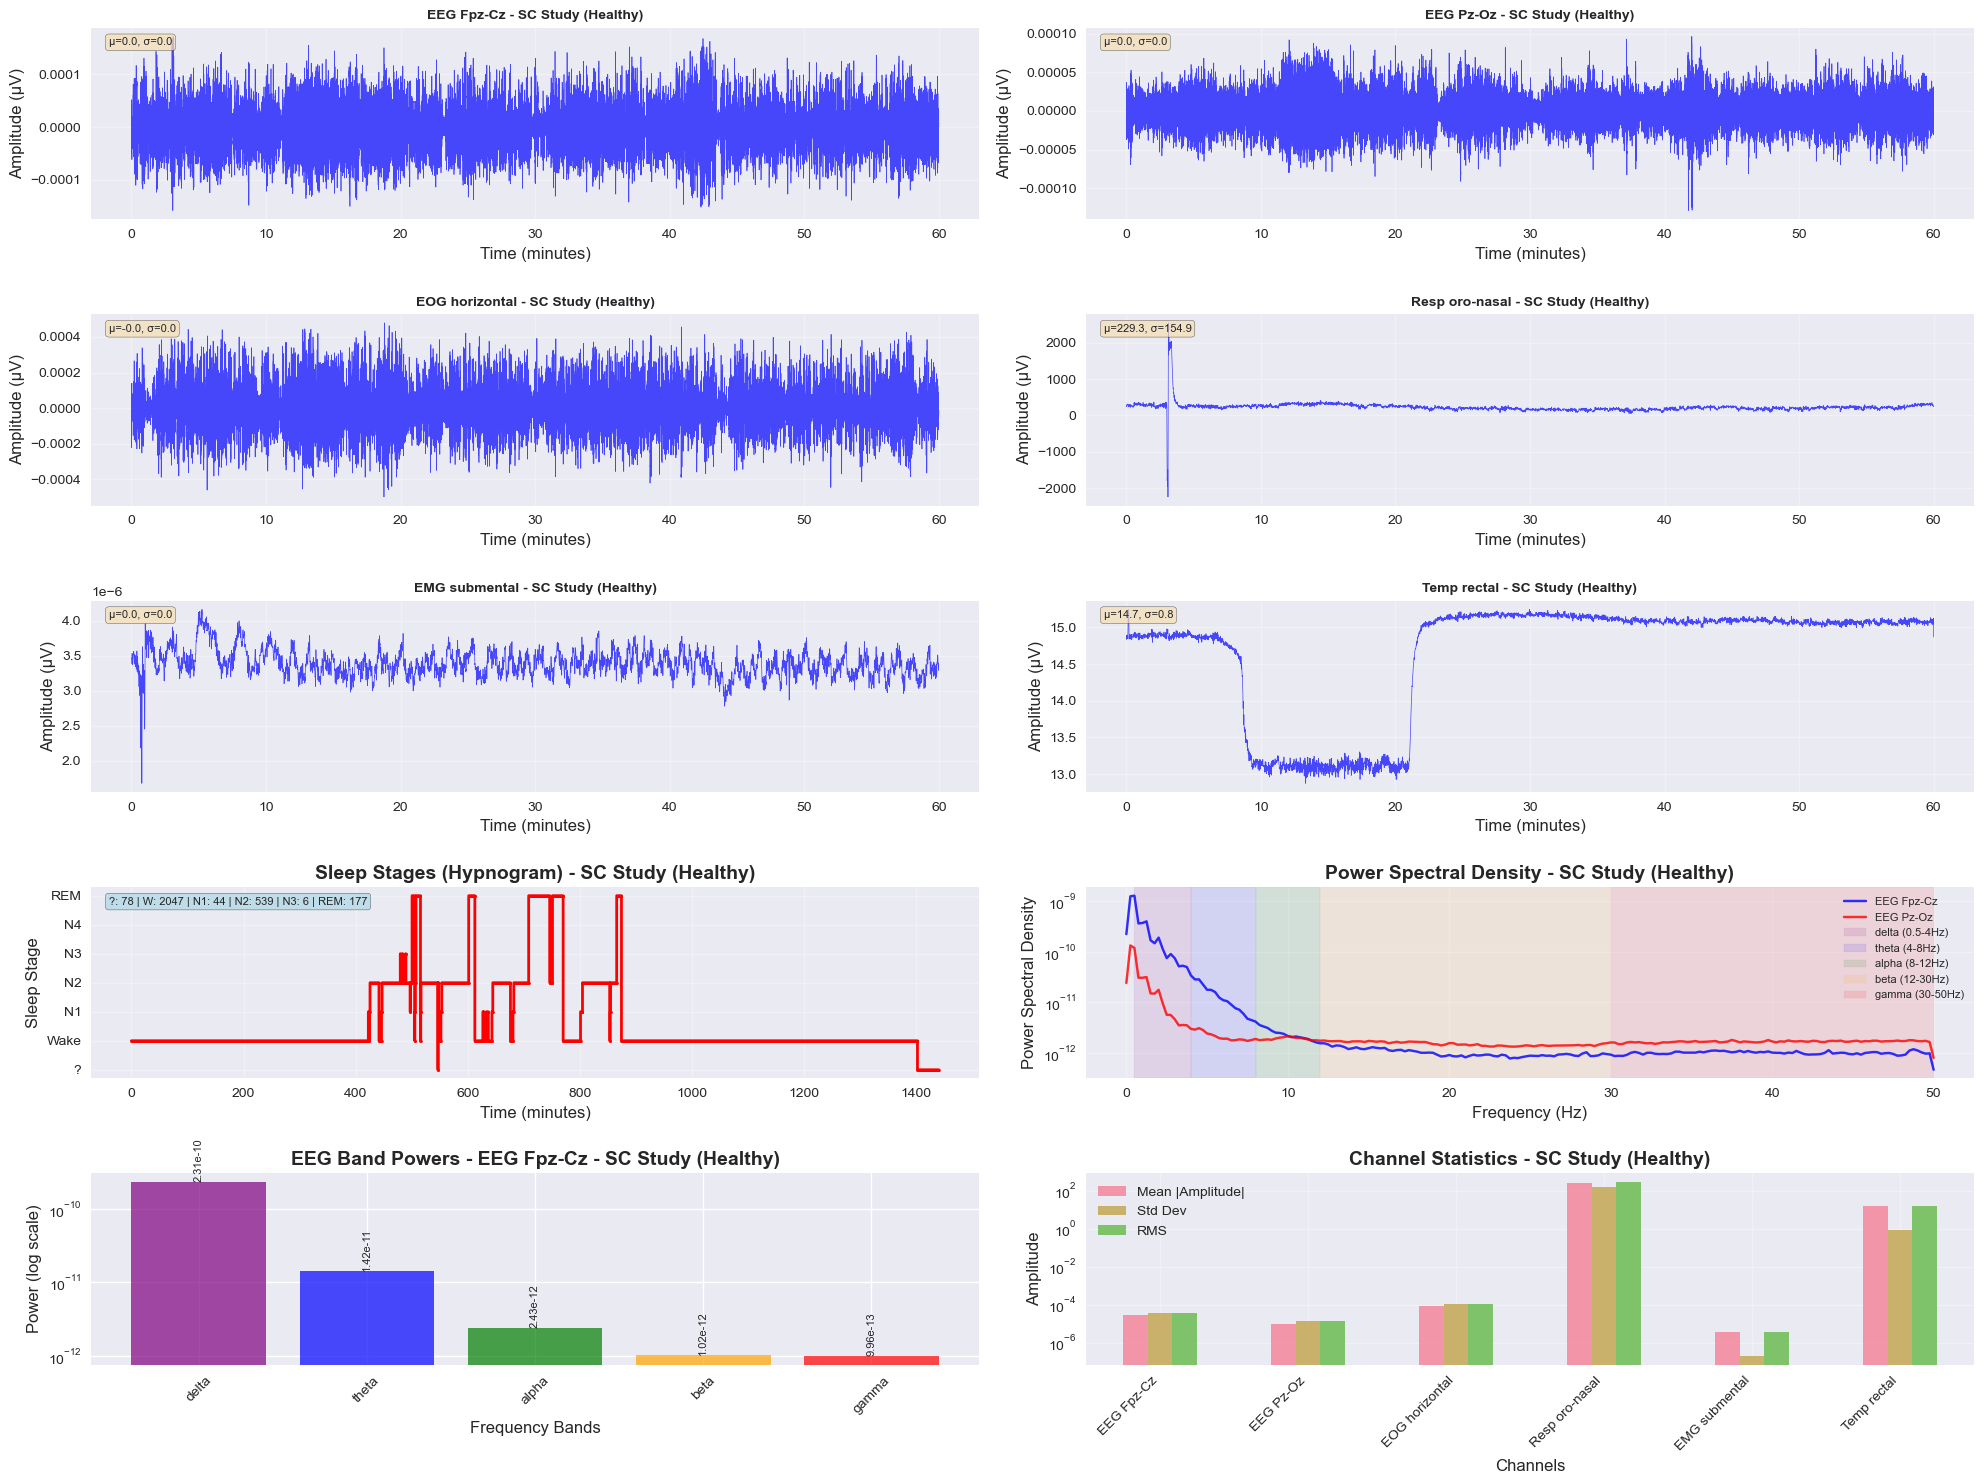


📊 ANALYSIS PAIR 2: ST Study
PSG File: ST7172J0-PSG.edf
Hypnogram: ST7172JA-Hypnogram.edf
🔍 Analyzing ST Study (Sleep Issues) - ST7172J0-PSG.edf
✅ PSG loaded: 100 Hz, 5 channels
📊 Channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']
✅ Hypnogram loaded: 199 annotations
💾 Comprehensive plot saved: ../results/sleep-edf/visualizations/st_study_(sleep_issues)_comprehensive_analysis.png


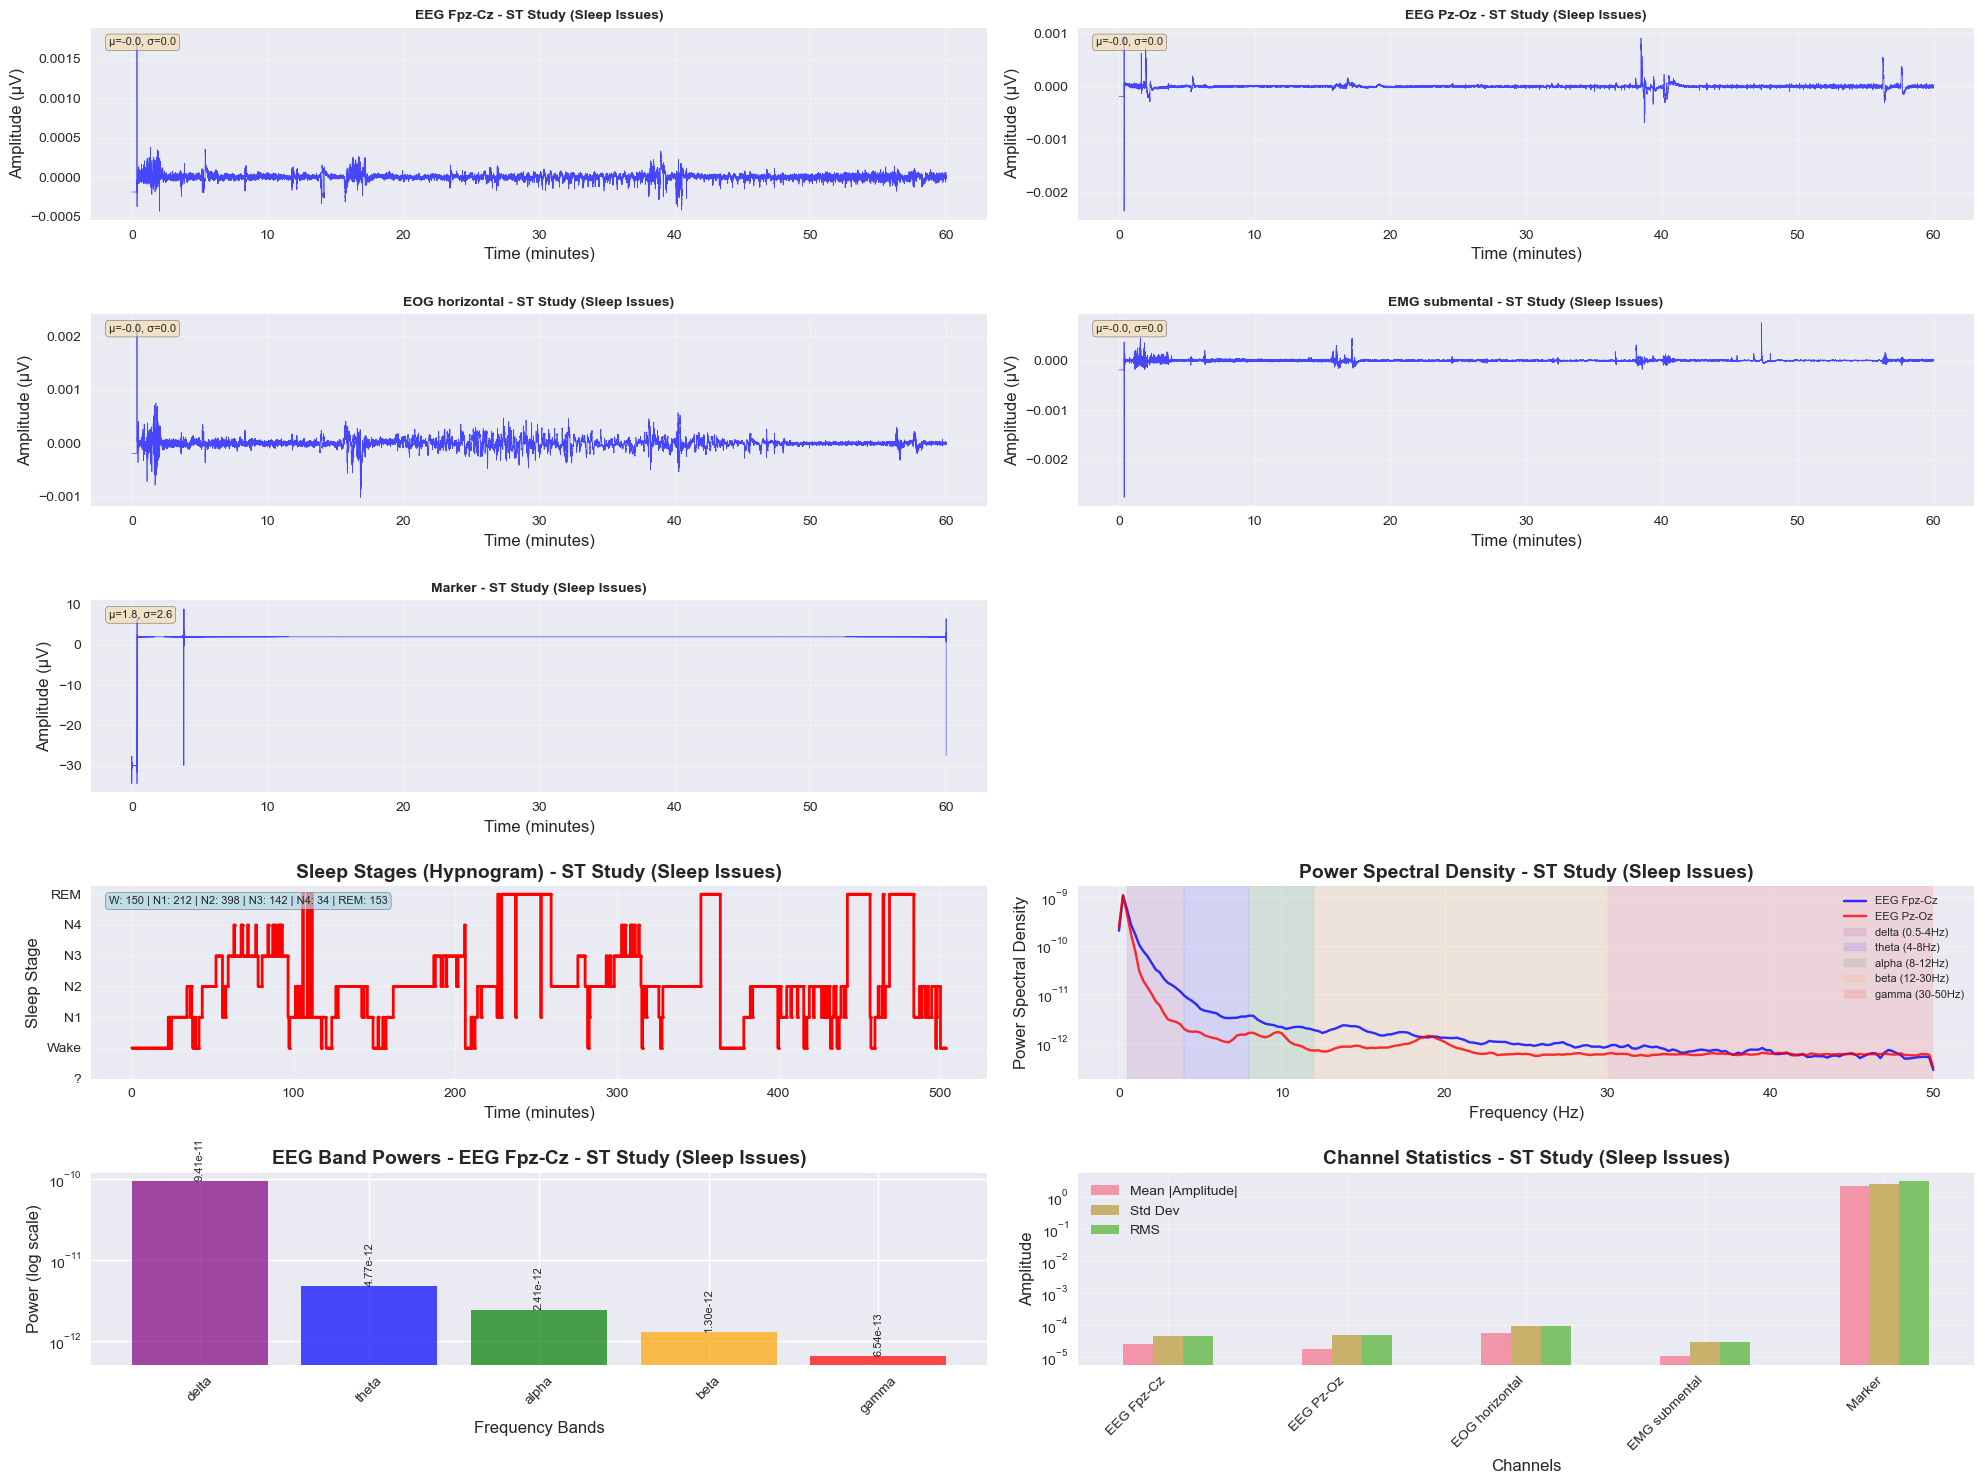


🔍 Comparative Analysis: SC vs ST Studies
💾 Comparative analysis saved: ../results/sleep-edf/visualizations/sc_vs_st_comparative_analysis.png


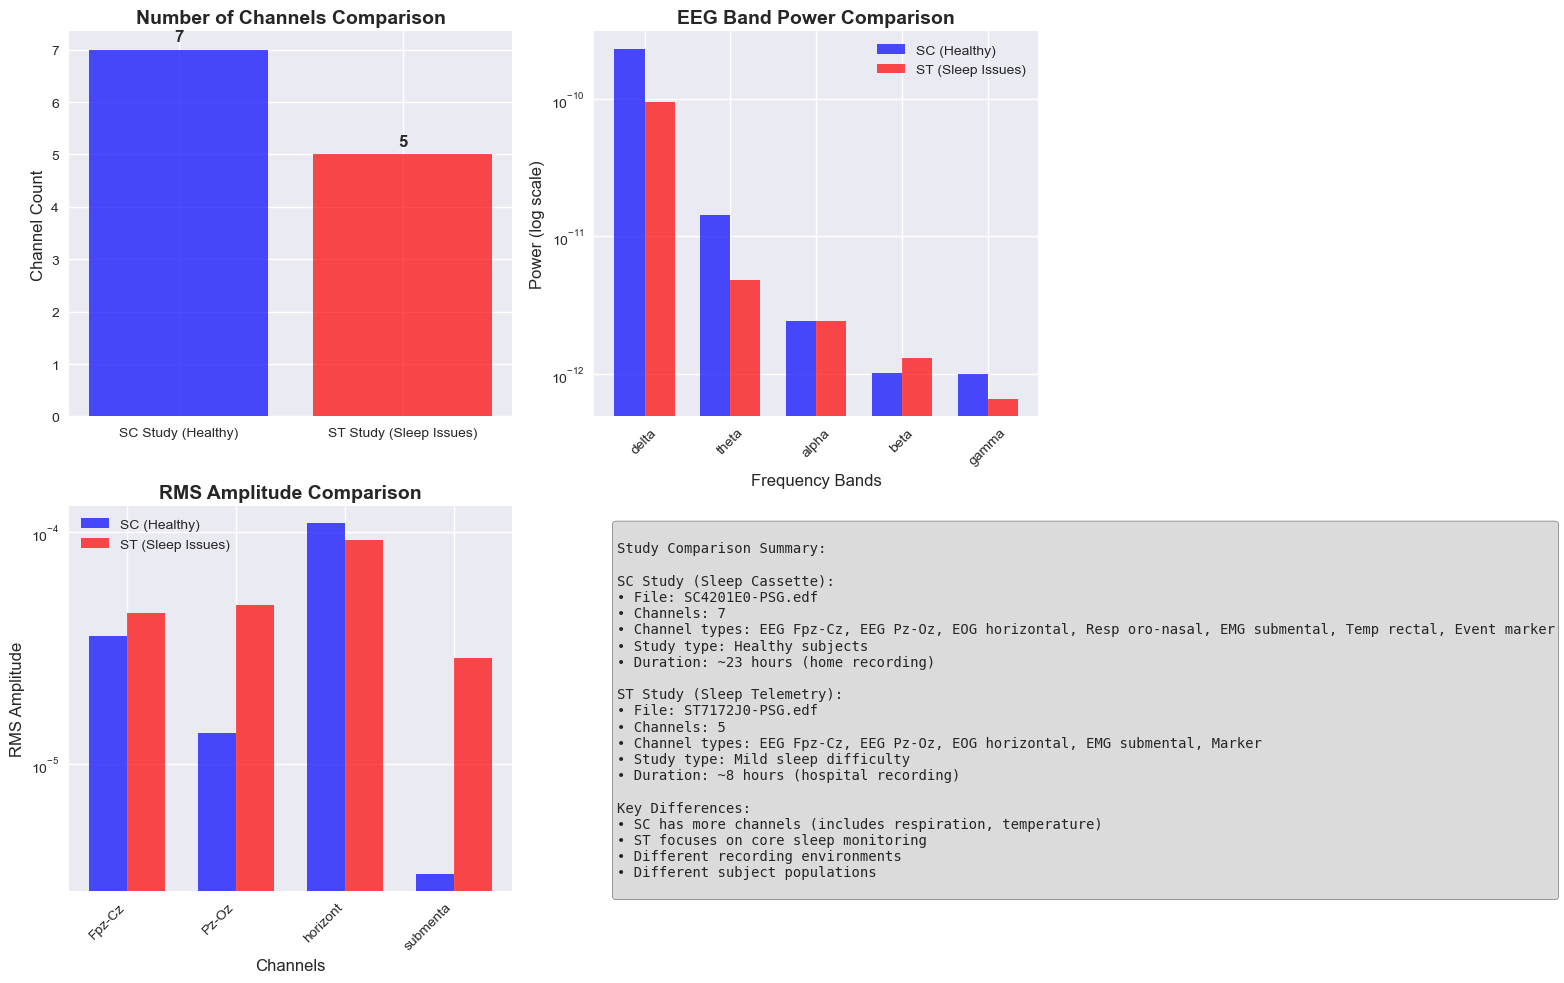


🎉 COMPREHENSIVE EDF ANALYSIS COMPLETE!
📁 All visualizations saved to: ../results/sleep-edf/visualizations
🔍 You can now see exactly what data looks like and what features are extracted!

✅ EDF Visualization Analysis Complete!


In [58]:
# Cell: Comprehensive EDF File Visualization and Feature Analysis

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import signal
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')


def visualize_edf_pair(psg_file, hypno_file, study_name, duration_minutes=30):
    """
    Comprehensive visualization of PSG and Hypnogram EDF files
    """

    print(f"🔍 Analyzing {study_name} - {psg_file.name}")
    print("=" * 60)

    # Load PSG file
    try:
        raw = mne.io.read_raw_edf(psg_file, preload=False, verbose=False)

        # Load a subset for visualization (first 30 minutes by default)
        duration_samples = int(duration_minutes * 60 * raw.info['sfreq'])
        raw_data = raw[:, :duration_samples][0]
        # Convert to minutes
        time_axis = np.arange(raw_data.shape[1]) / raw.info['sfreq'] / 60

        print(
            f"✅ PSG loaded: {raw.info['sfreq']:.0f} Hz, {len(raw.ch_names)} channels")
        print(f"📊 Channels: {raw.ch_names}")

    except Exception as e:
        print(f"❌ Error loading PSG: {str(e)}")
        return None

    # Load Hypnogram file
    hypno_data = None
    sleep_stages = None
    if hypno_file and hypno_file.exists():
        try:
            annotations = mne.read_annotations(hypno_file)

            # Convert annotations to time series for plotting
            hypno_times = []
            hypno_stages = []

            current_time = 0
            stage_mapping = {
                'Sleep stage W': 0,  # Wake
                'Sleep stage 1': 1,  # N1
                'Sleep stage 2': 2,  # N2
                'Sleep stage 3': 3,  # N3
                'Sleep stage 4': 4,  # N4
                'Sleep stage R': 5,  # REM
                'Sleep stage ?': -1  # Unknown
            }

            for onset, duration, desc in zip(annotations.onset, annotations.duration, annotations.description):
                stage_code = stage_mapping.get(desc, -1)
                # Create time points for this stage
                stage_times = np.linspace(
                    # 30-second epochs
                    onset/60, (onset + duration)/60, max(2, int(duration/30)))
                hypno_times.extend(stage_times)
                hypno_stages.extend([stage_code] * len(stage_times))

            hypno_data = (np.array(hypno_times), np.array(hypno_stages))
            sleep_stages = annotations
            print(f"✅ Hypnogram loaded: {len(annotations)} annotations")

        except Exception as e:
            print(f"⚠️  Warning: Could not load hypnogram: {str(e)}")

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 15))

    # 1. Raw Signal Visualization (Top 6 subplots)
    n_channels = min(6, len(raw.ch_names))

    for i in range(n_channels):
        ax = plt.subplot(5, 2, i+1)

        # Plot raw signal
        channel_data = raw_data[i]
        plt.plot(time_axis, channel_data, 'b-', alpha=0.7, linewidth=0.5)
        plt.title(f'{raw.ch_names[i]} - {study_name}',
                  fontsize=10, fontweight='bold')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Amplitude (µV)')
        plt.grid(True, alpha=0.3)

        # Add some statistics
        mean_val = np.mean(channel_data)
        std_val = np.std(channel_data)
        plt.text(0.02, 0.95, f'μ={mean_val:.1f}, σ={std_val:.1f}',
                 transform=ax.transAxes, fontsize=8, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

    # 2. Hypnogram Visualization (subplot 7)
    if hypno_data is not None:
        ax7 = plt.subplot(5, 2, 7)
        hypno_times, hypno_stages = hypno_data

        # Plot hypnogram
        plt.plot(hypno_times, hypno_stages, 'r-',
                 linewidth=2, marker='o', markersize=2)
        plt.title(
            f'Sleep Stages (Hypnogram) - {study_name}', fontweight='bold')
        plt.xlabel('Time (minutes)')
        plt.ylabel('Sleep Stage')
        plt.yticks([-1, 0, 1, 2, 3, 4, 5],
                   ['?', 'Wake', 'N1', 'N2', 'N3', 'N4', 'REM'])
        plt.grid(True, alpha=0.3)

        # Add stage statistics
        unique_stages, stage_counts = np.unique(
            hypno_stages, return_counts=True)
        stage_info = []
        for stage, count in zip(unique_stages, stage_counts):
            stage_names = {-1: '?', 0: 'W', 1: 'N1',
                           2: 'N2', 3: 'N3', 4: 'N4', 5: 'REM'}
            stage_info.append(f"{stage_names.get(stage, 'Unk')}: {count}")

        plt.text(0.02, 0.95, ' | '.join(stage_info),
                 transform=ax7.transAxes, fontsize=8, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

    # 3. Power Spectral Density Analysis (subplot 8)
    ax8 = plt.subplot(5, 2, 8)

    # Analyze EEG channels for PSD
    eeg_channels = [i for i, ch in enumerate(raw.ch_names) if 'EEG' in ch]

    if eeg_channels:
        colors = ['blue', 'red', 'green', 'orange']
        for idx, ch_idx in enumerate(eeg_channels[:4]):
            freqs, psd = signal.welch(
                raw_data[ch_idx], fs=raw.info['sfreq'], nperseg=int(raw.info['sfreq']*4))

            # Plot only up to 50 Hz for better visibility
            freq_mask = freqs <= 50
            plt.semilogy(freqs[freq_mask], psd[freq_mask],
                         color=colors[idx % len(colors)], label=raw.ch_names[ch_idx], alpha=0.8)

        # Mark frequency bands
        freq_bands = CONFIG['freq_bands']
        band_colors = {'delta': 'purple', 'theta': 'blue',
                       'alpha': 'green', 'beta': 'orange', 'gamma': 'red'}

        for band_name, (low, high) in freq_bands.items():
            plt.axvspan(low, high, alpha=0.1, color=band_colors.get(band_name, 'gray'),
                        label=f'{band_name} ({low}-{high}Hz)')

        plt.title(f'Power Spectral Density - {study_name}', fontweight='bold')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density')
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3)

    # 4. Feature Extraction Demonstration (subplot 9)
    ax9 = plt.subplot(5, 2, 9)

    # Extract and display key features
    features_demo = {}

    # EEG band powers
    if eeg_channels:
        ch_idx = eeg_channels[0]  # Use first EEG channel
        freqs, psd = signal.welch(
            raw_data[ch_idx], fs=raw.info['sfreq'], nperseg=int(raw.info['sfreq']*4))

        band_powers = []
        band_names = []

        for band_name, (low_freq, high_freq) in CONFIG['freq_bands'].items():
            band_mask = (freqs >= low_freq) & (freqs <= high_freq)
            if np.any(band_mask):
                band_power = np.mean(psd[band_mask])
                band_powers.append(band_power)
                band_names.append(band_name)
                features_demo[f'{raw.ch_names[ch_idx]}_{band_name}_power'] = band_power

        # Plot band powers
        bars = plt.bar(band_names, band_powers, color=[
                       'purple', 'blue', 'green', 'orange', 'red'], alpha=0.7)
        plt.yscale('log')
        plt.title(
            f'EEG Band Powers - {raw.ch_names[ch_idx]} - {study_name}', fontweight='bold')
        plt.xlabel('Frequency Bands')
        plt.ylabel('Power (log scale)')
        plt.xticks(rotation=45)

        # Add value labels on bars
        for bar, power in zip(bars, band_powers):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                     f'{power:.2e}', ha='center', va='bottom', fontsize=8, rotation=90)

    # 5. Signal Statistics Comparison (subplot 10)
    ax10 = plt.subplot(5, 2, 10)

    # Calculate statistics for all channels
    channel_stats = {}
    for i, ch_name in enumerate(raw.ch_names[:6]):  # First 6 channels
        if i < raw_data.shape[0]:
            ch_data = raw_data[i]
            channel_stats[ch_name] = {
                'mean': np.mean(np.abs(ch_data)),
                'std': np.std(ch_data),
                'rms': np.sqrt(np.mean(ch_data**2)),
                'range': np.ptp(ch_data)
            }

    # Plot statistics
    stats_df = pd.DataFrame(channel_stats).T
    stats_df[['mean', 'std', 'rms']].plot(kind='bar', ax=ax10, alpha=0.7)
    plt.title(f'Channel Statistics - {study_name}', fontweight='bold')
    plt.xlabel('Channels')
    plt.ylabel('Amplitude')
    plt.yscale('log')
    plt.xticks(rotation=45, ha='right')
    plt.legend(['Mean |Amplitude|', 'Std Dev', 'RMS'])
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the comprehensive plot
    plot_file = SLEEP_EDF_VISUALIZATIONS / \
        f"{study_name.lower().replace(' ', '_')}_comprehensive_analysis.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"💾 Comprehensive plot saved: {plot_file}")

    plt.show()

    # Return extracted features for comparison
    return {
        'study_name': study_name,
        'filename': psg_file.name,
        'channels': raw.ch_names,
        'features_demo': features_demo,
        'channel_stats': channel_stats,
        'sleep_stages': sleep_stages
    }


def create_comparative_analysis(sc_results, st_results):
    """Create comparative analysis between SC and ST studies"""

    print(f"\n🔍 Comparative Analysis: SC vs ST Studies")
    print("=" * 50)

    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Channel count comparison
    ax1 = axes[0, 0]
    studies = [sc_results['study_name'], st_results['study_name']]
    channel_counts = [len(sc_results['channels']), len(st_results['channels'])]

    bars1 = ax1.bar(studies, channel_counts, color=['blue', 'red'], alpha=0.7)
    ax1.set_title('Number of Channels Comparison', fontweight='bold')
    ax1.set_ylabel('Channel Count')

    for bar, count in zip(bars1, channel_counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 str(count), ha='center', va='bottom', fontweight='bold')

    # 2. EEG Band Power Comparison
    ax2 = axes[0, 1]

    # Extract common EEG features
    sc_features = sc_results['features_demo']
    st_features = st_results['features_demo']

    common_bands = []
    sc_powers = []
    st_powers = []

    for key in sc_features:
        if 'power' in key and any(band in key for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']):
            band_name = key.split('_')[1]  # Extract band name
            if any(st_key for st_key in st_features if band_name in st_key and 'power' in st_key):
                common_bands.append(band_name)
                sc_powers.append(sc_features[key])
                # Find corresponding ST power
                st_key = next(
                    st_key for st_key in st_features if band_name in st_key and 'power' in st_key)
                st_powers.append(st_features[st_key])

    if common_bands:
        x_pos = np.arange(len(common_bands))
        width = 0.35

        ax2.bar(x_pos - width/2, sc_powers, width,
                label='SC (Healthy)', color='blue', alpha=0.7)
        ax2.bar(x_pos + width/2, st_powers, width,
                label='ST (Sleep Issues)', color='red', alpha=0.7)

        ax2.set_title('EEG Band Power Comparison', fontweight='bold')
        ax2.set_xlabel('Frequency Bands')
        ax2.set_ylabel('Power (log scale)')
        ax2.set_yscale('log')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(common_bands, rotation=45)
        ax2.legend()

    # 3. Channel Statistics Comparison
    ax3 = axes[1, 0]

    # Compare RMS values of common channels
    sc_stats = sc_results['channel_stats']
    st_stats = st_results['channel_stats']

    common_channels = []
    sc_rms = []
    st_rms = []

    for ch in sc_stats:
        if ch in st_stats:
            common_channels.append(ch.replace('EEG ', '').replace(
                'EOG ', '').replace('EMG ', '')[:8])  # Truncate for display
            sc_rms.append(sc_stats[ch]['rms'])
            st_rms.append(st_stats[ch]['rms'])

    if common_channels:
        x_pos = np.arange(len(common_channels))
        width = 0.35

        ax3.bar(x_pos - width/2, sc_rms, width,
                label='SC (Healthy)', color='blue', alpha=0.7)
        ax3.bar(x_pos + width/2, st_rms, width,
                label='ST (Sleep Issues)', color='red', alpha=0.7)

        ax3.set_title('RMS Amplitude Comparison', fontweight='bold')
        ax3.set_xlabel('Channels')
        ax3.set_ylabel('RMS Amplitude')
        ax3.set_yscale('log')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(common_channels, rotation=45, ha='right')
        ax3.legend()

    # 4. Study Summary
    ax4 = axes[1, 1]
    ax4.axis('off')

    summary_text = f"""
Study Comparison Summary:

SC Study (Sleep Cassette):
• File: {sc_results['filename']}
• Channels: {len(sc_results['channels'])}
• Channel types: {', '.join(sc_results['channels'])}
• Study type: Healthy subjects
• Duration: ~23 hours (home recording)

ST Study (Sleep Telemetry):
• File: {st_results['filename']}
• Channels: {len(st_results['channels'])}
• Channel types: {', '.join(st_results['channels'])}
• Study type: Mild sleep difficulty
• Duration: ~8 hours (hospital recording)

Key Differences:
• SC has more channels (includes respiration, temperature)
• ST focuses on core sleep monitoring
• Different recording environments
• Different subject populations
    """

    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()

    # Save comparison plot
    comparison_file = SLEEP_EDF_VISUALIZATIONS / "sc_vs_st_comparative_analysis.png"
    plt.savefig(comparison_file, dpi=300, bbox_inches='tight')
    print(f"💾 Comparative analysis saved: {comparison_file}")

    plt.show()


# Main execution
print("🚀 Starting Comprehensive EDF Visualization Analysis...")
print("=" * 70)

# Get sample files for visualization
if 'file_structure' in globals():
    # Select sample files
    sc_psg_files = file_structure['SC_PSG'][:2]  # First 2 SC files
    st_psg_files = file_structure['ST_PSG'][:2]  # First 2 ST files
    sc_hypno_files = file_structure['SC_Hypnogram']
    st_hypno_files = file_structure['ST_Hypnogram']

    # Find matching hypnograms
    def find_matching_hypnogram(psg_file, hypno_files):
        """Find matching hypnogram file for a PSG file"""
        base_name = psg_file.name[:6]  # e.g., SC4201 or ST7172
        for hypno_file in hypno_files:
            if base_name in hypno_file.name:
                return hypno_file
        return None

    # Analyze SC Study pair
    if sc_psg_files:
        sc_psg = sc_psg_files[0]
        sc_hypno = find_matching_hypnogram(sc_psg, sc_hypno_files)

        print(f"\n📊 ANALYSIS PAIR 1: SC Study")
        print(f"PSG File: {sc_psg.name}")
        print(f"Hypnogram: {sc_hypno.name if sc_hypno else 'Not found'}")

        sc_results = visualize_edf_pair(
            sc_psg, sc_hypno, "SC Study (Healthy)", duration_minutes=60)

    # Analyze ST Study pair
    if st_psg_files:
        st_psg = st_psg_files[0]
        st_hypno = find_matching_hypnogram(st_psg, st_hypno_files)

        print(f"\n📊 ANALYSIS PAIR 2: ST Study")
        print(f"PSG File: {st_psg.name}")
        print(f"Hypnogram: {st_hypno.name if st_hypno else 'Not found'}")

        st_results = visualize_edf_pair(
            st_psg, st_hypno, "ST Study (Sleep Issues)", duration_minutes=60)

    # Create comparative analysis
    if 'sc_results' in locals() and 'st_results' in locals():
        create_comparative_analysis(sc_results, st_results)

    print(f"\n🎉 COMPREHENSIVE EDF ANALYSIS COMPLETE!")
    print(f"📁 All visualizations saved to: {SLEEP_EDF_VISUALIZATIONS}")
    print(f"🔍 You can now see exactly what data looks like and what features are extracted!")

else:
    print("❌ file_structure not found. Please run the data acquisition cells first.")

print(f"\n✅ EDF Visualization Analysis Complete!")